In [1]:
import pandas as pd
import mdtraj as md
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from __future__ import print_function
import seaborn as sns
from matplotlib.ticker import NullFormatter, MaxNLocator
from pandas.plotting import scatter_matrix
import matplotlib.ticker as ticker
#import plotly.graph_objects as go
import scipy as sp
from itertools import chain, combinations
import matplotlib as mpl
from matplotlib.lines import Line2D
from scipy import spatial
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
import scipy.stats as stats
#import statsmodels.stats.weightstats
from matplotlib import path
import matplotlib
from scipy.stats import probplot,shapiro, sem
#import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler

from matplotlib import cm
from collections import Counter
from numpy import linspace
#import umap.umap_ as umap
#import pylab
import os
#import PIL
from scipy.ndimage import gaussian_filter, uniform_filter1d

In [2]:
# import soursop
import afrc
import soursop
import MDAnalysis
import pandas as pd
import numpy as np
from soursop.sstrajectory import SSTrajectory
from Bio.PDB import *
from itertools import chain

In [3]:
print("MAKE SURE afrc_venv_ virtual environment is enabled with conda")
print("MAKE SURE python version is 3.9.18")
import sys
sys.version

MAKE SURE afrc_venv_ virtual environment is enabled with conda
MAKE SURE python version is 3.9.18


'3.9.18 (main, Jan 26 2024, 16:04:25) \n[GCC 8.5.0 20210514 (Red Hat 8.5.0-20)]'

# Some Functions

In [2]:
def RSA_based_fC(protein_var,protein_name,poly_id,
                       GW_moment_var,every_ith_snap,GW_every_ith_snap,radius_):
    x_total=[]
    y_total=[]
    if poly_id=='protein':
        protein_label=protein_name
        temp_protein=protein_var.copy()
        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)
        x_total=list(chain.from_iterable(x_total))
        y_total=list(chain.from_iterable(y_total))
        poly_var=protein_var.copy()
        protein_pro=poly_var[['ratio','RSA']].iloc[:every_ith_snap,:].copy()
        protein_pro['polymer_id']=np.repeat(protein_label,protein_pro.shape[0])
        del x_total, y_total, temp_protein
    else:
        return print('ERROR')

    GW_po=GW_moment_var[['ratio','RSA']][::GW_every_ith_snap].copy()
    GW_po['polymer_id']=np.repeat('GW',GW_po.shape[0])
    
    #calculate mean and stdev values (must keep same mean and stdev values)
    upto_snapshots=1000000
    GW_mean_ratio=np.mean(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_std_ratio=np.std(GW_po['ratio'].values[0:(upto_snapshots+1)])
    GW_mean_RSA=np.mean(GW_po['RSA'].values[0:(upto_snapshots+1)])
    GW_std_RSA=np.std(GW_po['RSA'].values[0:(upto_snapshots+1)])
        
    combined_pro_po=pd.concat([GW_po,protein_pro],axis=0,ignore_index=True)
    combined_pro_po['stdd_ratio']=(combined_pro_po['ratio'].values-GW_mean_ratio)/(GW_std_ratio)
    combined_pro_po['stdd_RSA']=(combined_pro_po['RSA'].values-GW_mean_RSA)/(GW_std_RSA)
    po_x=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_RSA'].values
    po_y=combined_pro_po[combined_pro_po.polymer_id=='GW']['stdd_ratio'].values
    pro_x=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_RSA'].values
    pro_y=combined_pro_po[combined_pro_po.polymer_id==protein_label]['stdd_ratio'].values
    
    GW_points=np.c_[po_x, po_y]
    protein_points=np.c_[pro_x, pro_y]    
    tree_GW=spatial.cKDTree(GW_points)
    tree_protein=spatial.cKDTree(protein_points)

    GW_not_in_range=[]
    j=0
    for point in GW_points:

        if not tree_protein.query_ball_point(point,radius_):
            GW_not_in_range.append(point)
        j+=1
        if j%100000==0:
            print(f'{j} GW snapshots completed')
                
    fC_by_distance=(GW_points.shape[0]-len(GW_not_in_range))/(GW_points.shape[0])
    return fC_by_distance    


In [3]:
def RSA_Rs_protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= 'RSA'
    y_variable=r'$R_s$'
    global fC_value, grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]


    x_polmodel_GW.append(testeq_GW['RSA'].values)
    y_polmodel_GW.append(testeq_GW['ratio'].values)

    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein.RSA.values)
        y_total.append(temp_protein.ratio.values)

        fC_value=RSA_based_fC(temp_protein,
                       protein_label,
                       second_obj,testeq_GW,
                       temp_protein.shape[0],
                       1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=1
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['RSA'].max()>max_x_val or testeq_GW['RSA'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    axTemperature.text(0.7,0.8,
                       '$f_C$= '+format(fC_value,'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



In [4]:
def protein_3dplot_against_GW(protein_var,protein_label,second_obj,provided_color):
    
    x_variable= r'$R_g\left/R_g^{theta}\right.$' 
    y_variable=r'$R_s$'
    global grid_protein, grid_GW

    testeq_GW= pd.read_csv('../segmented_chain_project/reference_GW_chainlen_100_for_RSA.csv')
    
    plt.rcParams["font.weight"] = "regular"
    plt.rcParams["axes.labelweight"] = "regular"
    
    
    x_polmodel_GW=[]
    y_polmodel_GW=[]
    x_total=[]
    y_total=[]

    scatter_markers=['d','x',4,'o','v','^','1','8','s','p','P','*','X','D',9]

    GW_rg = testeq_GW['Rg2']**0.5
    GW_rg_mean = GW_rg.mean()
    GW_rg_by_rg_mean = GW_rg/GW_rg_mean
    testeq_GW['Rg/Rg_mean'] = GW_rg_by_rg_mean
    
    x_polmodel_GW.append(GW_rg_by_rg_mean)
    y_polmodel_GW.append(testeq_GW['ratio'].values)
    
    if second_obj=='protein':        
        temp_protein =  protein_var.copy()

        x_total.append(temp_protein['Rg/Rg_theta'].values)
        y_total.append(temp_protein.ratio.values)

        # fC_value=RSA_based_fC(temp_protein,
        #                protein_label,
        #                second_obj,testeq_GW,
        #                temp_protein.shape[0],
        #                1,0.1)            
        del temp_protein
    else:
        print('ERROR. FIX ERROR')

    x_total=list(chain.from_iterable(x_total))
    y_total=list(chain.from_iterable(y_total))
    x_polmodel_GW=list(chain.from_iterable(x_polmodel_GW))
    y_polmodel_GW=list(chain.from_iterable(y_polmodel_GW))

    # Set up default x and y limits
    max_x_val=3
    max_y_val=30
    xlims = [0,max_x_val]
    ylims = [0,max_y_val]
    if testeq_GW['Rg/Rg_mean'].max()>max_x_val or testeq_GW['Rg/Rg_mean'].min()<0:
        return print('ERROR')
    elif max(x_total)>max_x_val or min(x_total)<0:
        return print('ERROR')        
    elif testeq_GW['ratio'].max()>max_y_val or testeq_GW['ratio'].min()<0:
        return print('ERROR')
    elif max(y_total)>max_y_val or min(y_total)<0:
        return print('ERROR')        

    # Set up your x and y labels
    xlabel = x_variable
    ylabel = y_variable

    # Define the locations for the axes

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left+width
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram


    # Set up the size of the figure
    fig = plt.figure(1, figsize=(5.2,5))

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram


    axHistx.axes.get_xaxis().set_visible(False)
    axHisty.axes.get_yaxis().set_visible(False)


    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    #
    # Define the number of bins
    nxbins = 100
    nybins = 50
    nbins = nxbins+nybins

    xbins = linspace(start = xmin, stop = xmax, num = nxbins)
    ybins = linspace(start = ymin, stop = ymax, num = nybins)
    xcenter = (xbins[0:-1]+xbins[1:])/2.0
    ycenter = (ybins[0:-1]+ybins[1:])/2.0
    aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)


    X = xcenter
    Y = ycenter

    axTemperature.scatter(x_polmodel_GW,y_polmodel_GW,
                      marker=scatter_markers[3],s=1,alpha=0.6,color='black',
                       label='GW')
    
    axTemperature.scatter(x_total,
               y_total,
               marker=scatter_markers[0],s=1,alpha=0.6,color=provided_color,
                                      label=protein_label)                



    #Plot the axes labels
    axTemperature.set_xlabel(xlabel,fontsize=12,labelpad = 1)
    axTemperature.set_ylabel(ylabel,fontsize=12, labelpad = 1)

    #Set up the plot limits
    axTemperature.set_xlim(xlims)
    axTemperature.set_ylim(ylims)

    #Set up the histogram bins
    xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
    ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)


    axHistx.hist(x_polmodel_GW, bins=xbins, color = 'black',histtype='step',
                linewidth = 0.7,density=True)
    axHistx.hist(x_total, bins=xbins, color = provided_color,histtype='step',
                label=protein_label,linewidth = 0.7,density=True)

    axHisty.hist(y_polmodel_GW, bins=np.arange(min(y_total),max(y_total),1), color = 'black',orientation='horizontal',histtype='step',
                linewidth = 0.7,density=True)

    axHisty.hist(y_total, bins=ybins, color = provided_color,orientation='horizontal',histtype='step',
                label=protein_label,linewidth = 0.7,density=True)    
    
    #original_n_divisions=100
    step_x=0.02#(min(x_polmodel_GW)-max(x_polmodel_GW))/original_n_divisions
    step_y=0.6#(min(y_polmodel_GW)-max(y_polmodel_GW))/original_n_divisions
    max_value_x=max(xlims)
    n_divisions_x=round((max_value_x-min(xlims))/step_x)
    
    max_value_y=max(ylims)
    n_divisions_y=round((max_value_y-min(ylims))/step_y)
    #gridx = np.linspace(min(x_polmodel_GW), max(x_polmodel_GW), n_divisions_x)
    gridx = np.linspace(min(xlims), max(xlims), n_divisions_x)
    #gridy = np.linspace(min(y_polmodel_GW), max(y_polmodel_GW), n_divisions_y)
    gridy = np.linspace(min(ylims), max(ylims), n_divisions_y)
    
    grid_protein, _, _ = np.histogram2d(x_total, y_total, bins=[gridx, gridy])
    grid_GW, _, _ = np.histogram2d(x_polmodel_GW, y_polmodel_GW, bins=[gridx, gridy])

    # axTemperature.text(0.7,0.8,
    #                    '$f_C$= '+format(fC_value,'0.3f'),
    #                   transform=axTemperature.transAxes,fontsize=8)
    axTemperature.text(0.7,0.74,
                       '$f_A$= '+format(np.count_nonzero(grid_protein)/np.count_nonzero(grid_GW),'0.3f'),
                      transform=axTemperature.transAxes,fontsize=8)    

    axTemp_legend=axTemperature.legend(fontsize=7,loc='upper right')

    frame = axTemp_legend.get_frame()
    frame.set_linewidth(1)
    frame.set_edgecolor('black')
    #axHisty.hist(y, bins=ybins, orientation='horizontal', color = provided_color)






    #Set up the histogram limits
    axHistx.set_xlim( xmin, xmax )
    axHisty.set_ylim( ymin, ymax )

    axHistx.set_ylabel('Prob. Density',fontsize=12)
    axHisty.set_xlabel('Prob. Density',fontsize=12)


    #Cool trick that changes the number of tickmarks for the histogram axes
    axHisty.xaxis.set_major_locator(MaxNLocator(4))
    axHistx.yaxis.set_major_locator(MaxNLocator(3))

    for i in ['top', 'left', 'right', 'bottom']:
        axHistx.spines[i].set_linewidth(1)
        axHisty.spines[i].set_linewidth(1)
        axTemperature.spines[i].set_linewidth(1)

    axHistx.minorticks_on()
    axHistx.tick_params(axis='y', which='major', labelsize=10, width = 0.8, pad = 2)
    axHistx.tick_params(axis='y', which='minor', width = 0.6)
    axHisty.minorticks_on()
    axHisty.tick_params(axis='x', which='major', labelsize=10, width = 0.8, pad = 2,labelrotation=270)
    axHisty.tick_params(axis='x', which='minor', width = 0.6)
    axTemperature.minorticks_on()
    axTemperature.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad = 2)
    axTemperature.tick_params(axis='both', which='minor', width = 0.6)    
    plt.setp(axTemperature.get_yticklabels()[-1], visible=False)
    plt.setp(axTemperature.get_xticklabels()[-1], visible=False)
    #fig.subplots_adjust(hspace=0.85,wspace=0.85)

    # Save to a File
    filename = 'GW_3d_plot'
    #plt.savefig(f'figures/GW_{protein_label}_3dplot.png', dpi = 1000, bbox_inches='tight')
    return 



# generate a dataframe connecting directory with seq_name in their property df

In [5]:
seq_name_AFRC = pd.read_csv('../holehouse_project/IDRome_shape_mean_size_mean_added.csv')

In [6]:
seq_name_dir_df = pd.read_csv('../larsen_paper_2023_compaction/seq_name_dir_df.csv')
seq_name_dir_df

,seq_name,seq_dir,protein_uniprot_id
0,H0YL14_1_46,IDROME_larsen/IDRome_v4/H0/YL/14/1_46,H0YL14
1,H0YL09_1_131,IDROME_larsen/IDRome_v4/H0/YL/09/1_131,H0YL09
2,H0YKK7_1_89,IDROME_larsen/IDRome_v4/H0/YK/K7/1_89,H0YKK7
3,H0YKK7_135_164,IDROME_larsen/IDRome_v4/H0/YK/K7/135_164,H0YKK7
4,H0YKK7_430_550,IDROME_larsen/IDRome_v4/H0/YK/K7/430_550,H0YKK7
...,...,...,...
28053,A3QJZ6_111_153,IDROME_larsen/IDRome_v4/A3/QJ/Z6/111_153,A3QJZ6
28054,A3QJZ7_106_152,IDROME_larsen/IDRome_v4/A3/QJ/Z7/106_152,A3QJZ7
28055,A3KN83_1001_1044,IDROME_larsen/IDRome_v4/A3/KN/83/1001_1044,A3KN83
28056,A3KN83_1_250,IDROME_larsen/IDRome_v4/A3/KN/83/1_250,A3KN83


In [7]:
seq_name_AFRC

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,z_omega_+,z_omega_-,z_omega_h,fdomain,nu_svr,SPR_svr,AFRC_mean_rg_theta,rg_rg_theta_mean,mean_inst_ratio,mean_RSA
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,0.000000,0.000000,-0.531910,0.000000,0.565,10.288,15.191941,1.057621,5.808555,0.442952
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,-0.043142,0.000000,0.061436,0.000000,0.532,10.107,14.102458,1.026155,5.598546,0.408551
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,0.384885,2.281943,1.092688,0.298507,0.537,10.167,20.524202,1.094369,5.764964,0.403545
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,0.799692,0.000000,0.627563,0.000000,0.509,10.018,28.732651,1.057445,5.766837,0.365432
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,1.947253,0.000000,0.090132,0.369565,0.578,10.316,17.085913,1.100872,6.130355,0.438200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,-1.319891,0.000000,0.163169,0.000000,0.520,9.993,33.590806,1.128366,5.388851,0.391268
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,-2.182869,0.000000,2.214949,0.000000,0.537,9.984,39.658059,1.156510,5.803936,0.394400
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,0.451957,2.132808,1.114749,0.513761,0.513,10.072,25.880343,1.164103,5.738483,0.426205
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,0.554013,2.234693,-1.942090,0.451327,0.512,10.063,26.561695,1.108354,5.813349,0.400844


# write function

In [8]:
def compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    protein_rg_theta = seq_name_AFRC[seq_name_AFRC.seq_name==seq_name].AFRC_mean_rg_theta.values[0]
    #convert nm to angstrom for lindorff-larsen data
    protein_rg_by_rg_theta = (np.load(f'{example_protein_dir}/rg.npy')*10)/protein_rg_theta
    protein_df = pd.DataFrame(zip(np.load(f'{example_protein_dir}/rg.npy')**2,
                                 protein_rg_by_rg_theta),columns=['Rg2','Rg/Rg_theta']).copy()
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [9]:
def RSA_Rs_compute_3dplot_from_seq_name(seq_name):
    global protein_df
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t = md.load(f'{example_protein_dir}/traj.xtc', top=f'{example_protein_dir}/top.pdb')
    t_df_moments = pd.DataFrame(md.principal_moments(t),columns=['R3','R2','R1']).iloc[10:,:].copy()
    t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
    t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
    t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
    protein_df = t_df_moments[['RSA']].copy()
    del t_df_moments
    protein_df['Rg2'] = np.load(f'{example_protein_dir}/rg.npy')**2
    protein_df['Ree2'] = np.load(f'{example_protein_dir}/ete.npy')**2
    protein_df['ratio'] = protein_df['Ree2']/protein_df['Rg2']
    return RSA_Rs_protein_3dplot_against_GW(protein_df,seq_name,'protein','magenta')

In [10]:
def load_trajectory(seq_name):
    #https://soursop.readthedocs.io/en/latest/usage/overview.html
    from soursop.sstrajectory import SSTrajectory
    global t_md, t_soursop,ree
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    t_soursop = SSTrajectory(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc',
                             f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    ree = np.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/ete.npy')
    ProtObj = t_soursop.proteinTrajectoryList[0]
    return ProtObj


In [11]:
#Rij is from lindorff-larsen
def Rij(traj):
    pairs = traj.top.select_pairs('all','all')
    d = md.compute_distances(traj,pairs)
    nres = traj.n_atoms
    ij = np.arange(2,nres,1)
    diff = [x[1]-x[0] for x in pairs]
    dij = np.empty(0)
    for i in ij:
        dij = np.append(dij,np.sqrt((d[:,diff==i]**2).mean().mean()))
    f = lambda x,R0,v : R0*np.power(x,v)
    popt, pcov = curve_fit(f,ij[ij>5],dij[ij>5],p0=[.4,.5])
    nu = popt[1]
    nu_err = pcov[1,1]**0.5
    R0 = popt[0]
    R0_err = pcov[0,0]**0.5
    return ij,dij,nu,nu_err,R0,R0_err

def calculate_nu_KLL_from_seq_name(seq_name, start_residue, end_residue):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name == seq_name].seq_dir.values[0]
    t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    # Skipping the first 10 frames
    t_md = t_md[10:]
    subsequence_indices = t_md.topology.select(f'residue {start_residue-1} to {end_residue-1}')
    
    subsequence_traj = t_md.atom_slice(subsequence_indices)

    ij, dij, nu, nu_err, R0, R0_err = Rij(subsequence_traj)
    return nu, nu_err

#original lindorff-larsen code,keeping as reference (Rij is original function from their github)
# def calculate_nu_KLL(seq_name):
#     example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
#     t_md = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc', 
#                    top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
#     ij,dij,nu,nu_err,R0,R0_err = Rij(t_md)
#     return nu

# def Rij(traj):
#     pairs = traj.top.select_pairs('all','all')
#     d = md.compute_distances(traj,pairs)
#     nres = traj.n_atoms
#     ij = np.arange(2,nres,1)
#     diff = [x[1]-x[0] for x in pairs]
#     dij = np.empty(0)
#     for i in ij:
#         dij = np.append(dij,np.sqrt((d[:,diff==i]**2).mean().mean()))
#     f = lambda x,R0,v : R0*np.power(x,v)
#     popt, pcov = curve_fit(f,ij[ij>5],dij[ij>5],p0=[.4,.5])
#     nu = popt[1]
#     nu_err = pcov[1,1]**0.5
#     R0 = popt[0]
#     R0_err = pcov[0,0]**0.5
#     return ij,dij,nu,nu_err,R0,R0_err

In [12]:
#master_df = master_df.reset_index(drop=True).copy()

# use  pyconformap shape vs size

In [13]:
exec(open("../larsen_paper_2023_compaction/pyconformap_modified.py").read())
def generate_2d_map(seq_name):
    location_of_files = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]    
    rg2_value = np.load(location_of_files+'/rg.npy')**2
    ree2_value = np.load(location_of_files+'/ete.npy')**2
    pd.DataFrame(zip(rg2_value,ree2_value),columns=['Rg2','Ree2']).to_csv(seq_name+'.csv',index=False)
    map_2d_seq_name = PyConforMap(seq_name+'.csv')
    map_2d_seq_name.plot_protein_against_GW(seq_name+'.csv')
    os.remove(seq_name+'.csv')
    return 

# combine the df


In [14]:
seq_name_fluctations = pd.read_csv('../larsen_paper_2023_compaction/HPC_computed_fC_values_all.csv').set_index('seq_name_list')
seq_stdev = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_stdev.csv').set_index('seq_name')
seq_ALBATROSS = pd.read_csv('../holehouse_project/IDRome_with_ALBATROSS_calculations.csv').set_index('seq_name')
seq_ranges = pd.read_csv('../holehouse_project/IDRome_Rg_Rs_RSA_range.csv').set_index('seq_name')
# the bounded_frac_size_shape is only for size-shape (through pyconformap_modified)


#add fP to the property df
seq_name_AFRC['fP'] = [seq.count('P')/len(seq) for seq in seq_name_AFRC.fasta.values]

#recalculate FCR
seq_name_AFRC['net_charge'] = [(seq.count('K')+seq.count('R')-seq.count('D')-seq.count('E'))/len(seq) for seq in seq_name_AFRC.fasta.values]

idrome_prop_flucs = pd.concat([seq_name_AFRC.set_index('seq_name'),
           seq_name_fluctations[['fC_shape_shape',
                                 'fA_shape_shape',
                                 'fC_size_shape',
                                 'fA_size_shape',
                                 'bounded_frac_size_shape']],
                              seq_stdev[['Rg_std','Rs_std','RSA_std']],
                              seq_ALBATROSS[['albatross_Rg','albatross_Rg_scaled','albatross_Ree','albatross_Ree_scaled',
                                             'albatross_scaling_exponent']],
                              seq_ranges[['Rg_range','Rs_range','RSA_range']]],
          axis=1).reset_index().rename(columns={'index':'seq_name'}).copy()

del seq_name_fluctations, seq_name_AFRC, seq_stdev, seq_ALBATROSS
idrome_prop_flucs

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,Rs_std,RSA_std,albatross_Rg,albatross_Rg_scaled,albatross_Ree,albatross_Ree_scaled,albatross_scaling_exponent,Rg_range,Rs_range,RSA_range
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,2.620898,0.200553,1.737755,1.737755,4.138554,4.251985,0.578297,0.790029,7.039022,0.537698
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,2.737865,0.201459,1.524150,1.524150,3.321804,3.321804,0.498650,0.756501,7.359276,0.538843
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,2.764873,0.181605,2.407502,2.407502,5.670386,5.788718,0.544833,1.185494,7.414943,0.500908
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,3.071942,0.183702,3.189458,3.189458,7.614085,7.813105,0.504434,1.620033,8.038966,0.485090
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,2.559872,0.187474,1.984436,1.984436,4.691561,4.962079,0.566668,0.945399,6.813072,0.499202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,2.880116,0.186104,4.129234,4.129234,9.571439,9.803478,0.534929,2.045043,7.521686,0.492647
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,3.086350,0.192582,4.447731,4.447731,10.693898,10.582268,0.504626,2.664859,7.982766,0.519563
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,2.783294,0.192728,3.285178,3.285178,7.447835,7.863577,0.570739,1.685618,7.465008,0.516141
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,2.866177,0.187885,3.052207,3.052207,7.340392,7.289317,0.541635,1.597735,7.462810,0.493407


In [15]:
idrome_prop_flucs.columns

Index(['seq_name', 'UniProt_ID', 'N', 'nu', 'SPR', 'ete2_Rg2', 'S', 'Delta',
       'Rg/nm', 'Ree/nm', 'Rh/nm', 'fK', 'fR', 'fE', 'fD', 'faro',
       'mean_lambda', 'shd', 'scd', 'kappa', 'fcr', 'ncpr', 'fasta',
       'is_btw_folded', 'is_nterm', 'is_cterm', 'is_idp', 'first', 'last',
       'N_FL', 'protein_name', 'gene_name', 'QCDpred', 'z_delta_+-',
       'z_omega_pi', 'z_omega_+', 'z_omega_-', 'z_omega_h', 'fdomain',
       'nu_svr', 'SPR_svr', 'AFRC_mean_rg_theta', 'rg_rg_theta_mean',
       'mean_inst_ratio', 'mean_RSA', 'fP', 'net_charge', 'fC_shape_shape',
       'fA_shape_shape', 'fC_size_shape', 'fA_size_shape',
       'bounded_frac_size_shape', 'Rg_std', 'Rs_std', 'RSA_std',
       'albatross_Rg', 'albatross_Rg_scaled', 'albatross_Ree',
       'albatross_Ree_scaled', 'albatross_scaling_exponent', 'Rg_range',
       'Rs_range', 'RSA_range'],
      dtype='object')

### DO NOT RUN the immediately below cell

In [16]:
#DO NOT run this cell
#these FOUR IDR simulations have low snapshots (<1000)
# %%time
# for seq_dir in seq_name_dir_df.seq_dir.values:
#     if np.load(seq_dir+'/rg.npy').shape[0]!=1000:
#         print(seq_name_dir_df[seq_name_dir_df.seq_dir==seq_dir].seq_name, np.load(seq_dir+'/rg.npy').shape[0])

3703    Q53SF7_218_1128
Name: seq_name, dtype: object 500
11700    Q7Z2Y5_341_1224
Name: seq_name, dtype: object 420
23881    Q9Y2W1_1_611
Name: seq_name, dtype: object 100
27365    Q9BXT5_1_968
Name: seq_name, dtype: object 100
CPU times: user 3.77 s, sys: 2.96 s, total: 6.73 s
Wall time: 14min 48s


In [16]:
#drop these FOUR IDR simulations because of low snapshots #
seq_name_dir_df = seq_name_dir_df[~seq_name_dir_df.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

idrome_prop_flucs = idrome_prop_flucs[~idrome_prop_flucs.seq_name.isin(['Q53SF7_218_1128',
                                             'Q7Z2Y5_341_1224',
                                             'Q9Y2W1_1_611',
                                             'Q9BXT5_1_968'])].copy()

## additional functions for visualization

In [17]:
print('NOTE: this is specifically for protamine simulations - will require some editing for others')
def compute_kmer_data_from_all_atom_simulation(seq_name,k_frac,sim_num):
    
    
    traj = md.load(f'/project/hshadman/hshadman/protamine_simulation/protamine_human/P1/explicit_solvent/more_nosalt_runs/explicit_continued_from_implicit/Rg_Ree/crd_dir/combined_{sim_num}.crd',
                   top=f'/project/hshadman/hshadman/protamine_simulation/protamine_human/P1/explicit_solvent/more_nosalt_runs/explicit_continued_from_implicit/Rg_Ree/stripped_{sim_num}.P1_box_{sim_num}.prmtop')


    topology = md.load_topology(f'/project/hshadman/hshadman/protamine_simulation/protamine_human/P1/explicit_solvent/more_nosalt_runs/explicit_continued_from_implicit/Rg_Ree/stripped_{sim_num}.P1_box_{sim_num}.prmtop')

    # Initialize an empty list to hold the sequence
    protein_sequence = []
    
    # Loop through each residue in the topology and get the residue name
    for residue in topology.residues:
        if residue.is_protein:  # Check if the residue is part of a protein
            protein_sequence.append(residue.name)
    
    # Convert three-letter codes to one-letter codes using a predefined dictionary
    three_to_one = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLU': 'E', 'GLN': 'Q', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
    }
    
    # Map three-letter codes to one-letter codes
    protein_sequence_one_letter = [three_to_one[res] for res in protein_sequence if res in three_to_one]
    
    # Join the sequence into a single string
    protein_sequence_str = ''.join(protein_sequence_one_letter)
    
    
    fasta_sequence = protein_sequence_str

    # for PROTAMINE make sure that it has 100000 frames and drop if it has extra
    if len(traj) > 100000:
        traj = traj[:100000]  # Truncate to the first 100000 frames if more are present

    # Select the last 40000 frames from the trajectory
    traj = traj[-40000:]    
    
    # Set the subsequence length k (replace 4 with your desired value)
    n_residues = traj.topology.n_residues
    k = round(traj.topology.n_residues/k_frac)

    complete_protein_rgyr = np.mean(md.compute_rg(traj))
    first_bead_index = traj.topology.select(f"residue {0} and name CA")[0]
    last_bead_index = traj.topology.select(f"residue {n_residues-1} and name CA")[0]
    end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
    end_to_end_distances = end_to_end_distances.flatten()
    complete_protein_ete = end_to_end_distances
    complete_protein_inst_ratio = np.mean((complete_protein_ete**2)/(complete_protein_rgyr**2))
    
    complete_protein_moments = pd.DataFrame(md.principal_moments(traj),columns=['R3','R2','R1']).copy()
    complete_protein_moments['asphericity']=complete_protein_moments.R1.values-(0.5*(complete_protein_moments.R2.values+complete_protein_moments.R3.values))
    complete_protein_moments['acylindricity']=complete_protein_moments.R2.values-complete_protein_moments.R3.values
    complete_protein_moments['RSA']=(complete_protein_moments.asphericity.values**2+(0.75*complete_protein_moments.acylindricity.values**2))/(complete_protein_moments.R1.values+complete_protein_moments.R2.values+complete_protein_moments.R3.values)**2
    complete_protein_RSA = np.mean(complete_protein_moments['RSA'].values)
    
    #AFRC
    complete_protein_afrc_init = afrc.AnalyticalFRC(fasta_sequence)
    complete_protein_rg_theta_mean = complete_protein_afrc_init.get_mean_radius_of_gyration()
    complete_protein_rg_rg_theta_mean = np.mean((10*md.compute_rg(traj))/complete_protein_rg_theta_mean)

    del first_bead_index, last_bead_index, end_to_end_distances
    j = 0
    # Iterate through each subsequence of k residues
    for start_res in range(1, n_residues - k + 2):  # Ensures we don't go out of bounds
        # Select k consecutive residues
        selection_string = f"residue {start_res-1} to {start_res + k - 2}"  # MDTraj is zero-indexed
        subsequence_indices = traj.topology.select(selection_string)
        
        fasta_slice = fasta_sequence[(start_res-1):(start_res + k - 1)]
        running_df = pd.DataFrame(np.repeat(fasta_slice,traj.n_frames),columns=['fasta_sequence'])
        running_df['start_res_zeroindex'] = np.repeat(start_res-1,traj.n_frames)
        running_df['end_res_zeroindex'] = np.repeat(start_res + k - 2,traj.n_frames)
        running_df['full_protein_fasta'] = np.repeat(fasta_sequence,traj.n_frames)
        
        running_df['full_protein_rgyr'] = np.repeat(complete_protein_rgyr,traj.n_frames)
        running_df['full_protein_inst_ratio'] = np.repeat(complete_protein_inst_ratio,traj.n_frames)
        running_df['full_protein_RSA'] = np.repeat(complete_protein_RSA,traj.n_frames)
        running_df['full_protein_rg_rg_theta_mean'] = np.repeat(complete_protein_rg_rg_theta_mean,traj.n_frames)
        
        running_df['sim'] = np.repeat(sim_num,traj.n_frames)
        running_df['seq_name'] = np.repeat(seq_name,traj.n_frames)
        # Create a trajectory slice for the selected subsequence
        subsequence_traj = traj.atom_slice(subsequence_indices)
        
        # Calculate the radius of gyration for the subsequence over all remaining frames
        rgyr = md.compute_rg(subsequence_traj)
        running_df['Rg/nm'] = rgyr
        
        # Select indices for the first and last bead in the subsequence for end-to-end distance calculation
        first_bead_index = traj.topology.select(f"residue {start_res-1} and name CA")[0]
        last_bead_index = traj.topology.select(f"residue {start_res + k - 2} and name CA")[0]
    
        # Calculate end-to-end distances for the subsequence over all remaining frames
        end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
        end_to_end_distances = end_to_end_distances.flatten()
        running_df['ete'] = end_to_end_distances
        running_df['inst_ratio'] = (running_df['ete'].values**2)/(running_df['Rg/nm'].values**2)
        
        t_df_moments = pd.DataFrame(md.principal_moments(subsequence_traj),columns=['R3','R2','R1']).copy()
        t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
        t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
        t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
        running_df['RSA'] = t_df_moments['RSA'].values

        #AFRC
        afrc_init = afrc.AnalyticalFRC(fasta_slice)
        rg_theta_mean = afrc_init.get_mean_radius_of_gyration()
        running_df['AFRC_mean_rg_theta'] = np.repeat(rg_theta_mean,traj.n_frames)
        running_df['rg_rg_theta_mean'] = (10*running_df['Rg/nm'].values)/running_df['AFRC_mean_rg_theta'].values
        
        if j == 0:
            master_df = running_df.copy()
        elif j>0:
            master_df = pd.concat([master_df,running_df],axis=0).copy()
        del running_df, t_df_moments
        print(f"residue {start_res-1} to {start_res + k - 2} done")
        j+=1
    print('ALL DONE')    
    return master_df

NOTE: this is specifically for protamine simulations - will require some editing for others


In [18]:
def compute_kmer_data_from_seq_name(seq_name,k_frac):
    example_protein_dir = seq_name_dir_df[seq_name_dir_df.seq_name==seq_name].seq_dir.values[0]
    
    traj = md.load(f'../larsen_paper_2023_compaction/{example_protein_dir}/traj.xtc',
                   top=f'../larsen_paper_2023_compaction/{example_protein_dir}/top.pdb')
    
    fasta_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0]
    
    # Skipping the first 10 frames
    traj = traj[10:]    
    
    # Set the subsequence length k (replace 4 with your desired value)
    n_residues = traj.topology.n_residues
    k = round(traj.topology.n_residues/k_frac)

    complete_protein_rgyr = np.mean(md.compute_rg(traj))
    complete_protein_nu = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[0]
    complete_protein_nu_err = calculate_nu_KLL_from_seq_name(seq_name, 1, n_residues)[1]
    first_bead_index = traj.topology.select(f"residue {0}")[0]
    last_bead_index = traj.topology.select(f"residue {n_residues - 1}")[0]    
    end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
    end_to_end_distances = end_to_end_distances.flatten()
    complete_protein_ete = end_to_end_distances
    complete_protein_inst_ratio = np.mean((complete_protein_ete**2)/(complete_protein_rgyr**2))
    
    complete_protein_moments = pd.DataFrame(md.principal_moments(traj),columns=['R3','R2','R1']).copy()
    complete_protein_moments['asphericity']=complete_protein_moments.R1.values-(0.5*(complete_protein_moments.R2.values+complete_protein_moments.R3.values))
    complete_protein_moments['acylindricity']=complete_protein_moments.R2.values-complete_protein_moments.R3.values
    complete_protein_moments['RSA']=(complete_protein_moments.asphericity.values**2+(0.75*complete_protein_moments.acylindricity.values**2))/(complete_protein_moments.R1.values+complete_protein_moments.R2.values+complete_protein_moments.R3.values)**2
    complete_protein_RSA = np.mean(complete_protein_moments['RSA'].values)    

    #AFRC
    complete_protein_afrc_init = afrc.AnalyticalFRC(fasta_sequence)
    complete_protein_rg_theta_mean = complete_protein_afrc_init.get_mean_radius_of_gyration()
    complete_protein_rg_rg_theta_mean = np.mean((10*md.compute_rg(traj))/complete_protein_rg_theta_mean)

    
    j = 0
    # Iterate through each subsequence of k residues
    for start_res in range(1, n_residues - k + 2):  # Ensures we don't go out of bounds
        # Select k consecutive residues
        selection_string = f"residue {start_res-1} to {start_res + k - 2}"  # MDTraj is zero-indexed
        subsequence_indices = traj.topology.select(selection_string)
        
        fasta_slice = fasta_sequence[(start_res-1):(start_res + k - 1)]
        running_df = pd.DataFrame(np.repeat(fasta_slice,traj.n_frames),columns=['fasta_sequence'])
        running_df['start_res_zeroindex'] = np.repeat(start_res-1,traj.n_frames)
        running_df['end_res_zeroindex'] = np.repeat(start_res + k - 2,traj.n_frames)
        running_df['full_protein_fasta'] = np.repeat(fasta_sequence,traj.n_frames)

        running_df['full_protein_rgyr'] = np.repeat(complete_protein_rgyr,traj.n_frames)
        running_df['full_protein_nu_recompute'] = np.repeat(complete_protein_nu,traj.n_frames)
        running_df['full_protein_nu_recompute_err'] = np.repeat(complete_protein_nu_err,traj.n_frames)
        running_df['full_protein_ratio'] = np.repeat(complete_protein_inst_ratio,traj.n_frames)
        running_df['full_protein_RSA'] = np.repeat(complete_protein_RSA,traj.n_frames)
        running_df['full_protein_rg_rg_theta_mean'] = np.repeat(complete_protein_rg_rg_theta_mean,traj.n_frames)
        
        running_df['seq_name'] = np.repeat(seq_name,traj.n_frames)
        # Create a trajectory slice for the selected subsequence
        subsequence_traj = traj.atom_slice(subsequence_indices)
        
        # Calculate the radius of gyration for the subsequence over all remaining frames
        rgyr = md.compute_rg(subsequence_traj)
        running_df['Rg/nm'] = rgyr

        #calculate nu
        subsequence_nu = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[0]
        subsequence_nu_err = calculate_nu_KLL_from_seq_name(seq_name, start_res, start_res + k - 1)[1]
        running_df['nu_recompute'] = np.repeat(subsequence_nu,traj.n_frames)
        running_df['nu_recompute_err'] = np.repeat(subsequence_nu_err,traj.n_frames)
        
        # Select indices for the first and last bead in the subsequence for end-to-end distance calculation
        first_bead_index = traj.topology.select(f"residue {start_res-1}")[0]
        last_bead_index = traj.topology.select(f"residue {start_res + k - 2}")[0]
    
        # Calculate end-to-end distances for the subsequence over all remaining frames
        end_to_end_distances = md.compute_distances(traj, [[first_bead_index, last_bead_index]])
        end_to_end_distances = end_to_end_distances.flatten()
        running_df['ete'] = end_to_end_distances
        running_df['inst_ratio'] = (running_df['ete'].values**2)/(running_df['Rg/nm'].values**2)
        
        t_df_moments = pd.DataFrame(md.principal_moments(subsequence_traj),columns=['R3','R2','R1']).copy()
        t_df_moments['asphericity']=t_df_moments.R1.values-(0.5*(t_df_moments.R2.values+t_df_moments.R3.values))
        t_df_moments['acylindricity']=t_df_moments.R2.values-t_df_moments.R3.values
        t_df_moments['RSA']=(t_df_moments.asphericity.values**2+(0.75*t_df_moments.acylindricity.values**2))/(t_df_moments.R1.values+t_df_moments.R2.values+t_df_moments.R3.values)**2
        running_df['RSA'] = t_df_moments['RSA'].values

        #AFRC
        afrc_init = afrc.AnalyticalFRC(fasta_slice)
        rg_theta_mean = afrc_init.get_mean_radius_of_gyration()
        running_df['AFRC_mean_rg_theta'] = np.repeat(rg_theta_mean,traj.n_frames)
        running_df['rg_rg_theta_mean'] = (10*running_df['Rg/nm'].values)/running_df['AFRC_mean_rg_theta'].values
        
        if j == 0:
            master_df = running_df.copy()
        elif j>0:
            master_df = pd.concat([master_df,running_df],axis=0).copy()
        del running_df, t_df_moments
        print(f"residue {start_res-1} to {start_res + k - 2} done")
        j+=1
    print('ALL DONE')    
    return master_df

In [19]:
def plot_protein_composition(seq_name):
    protein_sequence = idrome_prop_flucs[idrome_prop_flucs.seq_name==seq_name].fasta.values[0]
    # Define the groups and their respective amino acids
    groups = {
        'Negative (E/D)': ['E', 'D'],
        'Positive (R/K)': ['R', 'K'],
        'Proline (P)': ['P'],
        'Aromatic (Y/F/W)': ['Y', 'F', 'W'],
        'Aliphatic (I/L/M/V)': ['I', 'L', 'M', 'V']
    }
    
    # Colors corresponding to each group, including 'Uncategorized'
    colors = {
        'Negative (E/D)': 'red',
        'Positive (R/K)': 'blue',
        'Proline (P)': 'purple',
        'Aromatic (Y/F/W)': 'yellow',
        'Aliphatic (I/L/M/V)': 'grey',
        'Uncategorized': 'lightgrey'
    }
    
    # Count the frequency of each group in the sequence
    group_count = {group: 0 for group in groups}
    categorized_count = 0  # Track categorized residues to find uncategorized ones

    for aa in protein_sequence:
        found = False
        for group, aas in groups.items():
            if aa in aas:
                group_count[group] += 1
                categorized_count += 1
                found = True
                break
        if not found:
            group_count.setdefault('Uncategorized', 0)
            group_count['Uncategorized'] += 1
    
    # Prepare data for the pie chart
    labels = [group for group in group_count if group_count[group] > 0]
    sizes = [group_count[group] for group in labels]
    plot_colors = [colors[label] for label in labels]
    
    # Create pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct=lambda pct: f"{pct:.1f}%", startangle=90, colors=plot_colors)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


In [20]:
def assign_properties(residue):
    properties = {
        'negative': ['E', 'D'],
        'positive': ['R', 'K'],
        'proline': ['P'],
        'aromatic': ['Y', 'F', 'W'],
        'aliphatic': ['I', 'L', 'M', 'V']
    }
    colors = {
        'negative': 'red',
        'positive': 'blue',
        'proline': 'purple',
        'aromatic': 'yellow',
        'aliphatic': 'white'  # Visibility adjustment with black edge
    }
    size = 0
    color = 'black'
    for prop, residues in properties.items():
        if residue in residues:
            color = colors[prop]
            size = 80  # Adjust size for visual distinction
            break
    return color, size
def subchain_Rg_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rg = df.groupby('mid_residue').agg({
        'Rg/nm': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rg.columns = ['mid_residue', 'mean', 'std', 'color', 'size']

    fig, ax = plt.subplots(figsize=(figwidth, figheight))
    
    # Plotting
    ax.plot(stats_rg['mid_residue'], stats_rg['mean'], color='black', zorder=1)
    ax.fill_between(stats_rg['mid_residue'], 
                     stats_rg['mean'] - (stats_rg['std']/2), 
                     stats_rg['mean'] + (stats_rg['std']/2), 
                     color='gray', alpha=0.2, zorder=1)
    global_var = df.full_protein_rgyr.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <$R_g$> = {format(global_var, "0.2f")} nm',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rg.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <$R_g$> (nm)', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Proline (P)', markersize=10, markerfacecolor='purple',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aromatic (Y/F/W)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aliphatic (I/L/M/V)', markersize=10, markerfacecolor='white',
               markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return 



In [21]:
def subchain_Rs_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rs = df.groupby('mid_residue').agg({
        'inst_ratio': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rs.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rs['mid_residue'], stats_rs['mean'], color='black', zorder=1)
    ax.fill_between(stats_rs['mid_residue'], 
                     stats_rs['mean'] - (stats_rs['std']/2), 
                     stats_rs['mean'] + (stats_rs['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_inst_ratio.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <$R_s$> = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rs.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <$R_s$>', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Proline (P)', markersize=10, markerfacecolor='purple',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aromatic (Y/F/W)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aliphatic (I/L/M/V)', markersize=10, markerfacecolor='white',
               markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return
    


In [22]:
def subchain_RSA_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'RSA': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)
    
    global_var = df.full_protein_RSA.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, f'Global <RSA> = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 22)
        
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel('Local <RSA>', fontsize=12)
    
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Proline (P)', markersize=10, markerfacecolor='purple',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aromatic (Y/F/W)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aliphatic (I/L/M/V)', markersize=10, markerfacecolor='white',
               markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

In [23]:
def subchain_Rg_Rg_theta_mean_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'rg_rg_theta_mean': ['mean', 'std'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_rg_rg_theta_mean.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, r'Global <$R_g\left/R_g^{theta}\right.$>'+f' = {format(global_var, "0.2f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 24)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel(r'Local <$R_g\left/R_g^{theta}\right.$>', fontsize=12)
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Proline (P)', markersize=10, markerfacecolor='purple',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aromatic (Y/F/W)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aliphatic (I/L/M/V)', markersize=10, markerfacecolor='white',
               markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

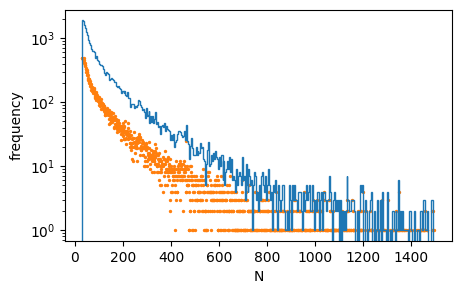

In [48]:
fig,ax = plt.subplots(figsize=(5,3))

ax.hist(idrome_prop_flucs.N.values,histtype='step',bins = np.arange(idrome_prop_flucs.N.min(),idrome_prop_flucs.N.max(),4))
ax.scatter(np.unique(idrome_prop_flucs.N.values,return_counts=True)[0],np.unique(idrome_prop_flucs.N.values,return_counts=True)[1],s=2)
#ax.set_xlim(30,1400)
ax.set_xlabel('N')
ax.set_ylabel('frequency')
ax.set_yscale('log')

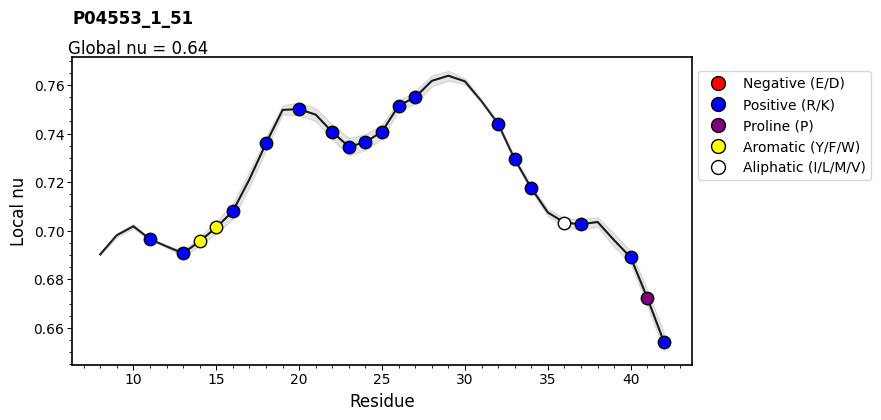

In [43]:
df = pd.read_csv('humanP1_all_subchains.csv')
subchain_nu_plot(df,8,4)

In [42]:
print(r'$\nu$')

$\nu$


In [37]:
def subchain_nu_plot(df,figwidth,figheight):
    # Calculate the midpoint for plotting and the properties for each midpoint
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]),
                                     axis=1, result_type='expand')
    
    # Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
    stats_rsa = df.groupby('mid_residue').agg({
        'nu_recompute': ['mean'],
        'nu_recompute_err': ['mean'],
        'color': lambda x: x.mode()[0],
        'size': lambda x: x.mode()[0]
    }).reset_index()
    
    # Flatten the MultiIndex
    stats_rsa.columns = ['mid_residue', 'mean', 'std', 'color', 'size']
    
    fig, ax = plt.subplots(figsize=(figwidth,figheight))
    
    # Plotting
    ax.plot(stats_rsa['mid_residue'], stats_rsa['mean'], color='black', zorder=1)
    ax.fill_between(stats_rsa['mid_residue'], 
                     stats_rsa['mean'] - (stats_rsa['std']/2), 
                     stats_rsa['mean'] + (stats_rsa['std']/2), 
                     color='gray', alpha=0.2, zorder=1)

    global_var = df.full_protein_nu_recompute.unique()[0]
    if global_var>=np.min(ax.get_ylim()) and global_var<=np.max(ax.get_ylim()):
        ax.axhline(y=global_var, color='black', linestyle='--')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')
    else:
        fig.text(0.12, 0.879, r'Global nu'+f' = {format(global_var, "0.3f")}',
                 fontsize=12, verticalalignment='bottom', horizontalalignment='left')
        ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold',pad = 24)
    
    # Adjust scatter plot to use different sizes and colors with higher zorder
    for i, row in stats_rsa.iterrows():
        ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)
    
    ax.set_xlabel('Residue', fontsize=12)
    ax.set_ylabel(r'Local nu', fontsize=12)
    
    # Customizing the plot border thickness
    for spine in ['top', 'left', 'right', 'bottom']:
        ax.spines[spine].set_linewidth(1.2)
    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
    ax.tick_params(axis='both', which='minor', width=0.6)
    
    # Create custom legend with circles and edge color for white patch
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Proline (P)', markersize=10, markerfacecolor='purple',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aromatic (Y/F/W)', markersize=10, markerfacecolor='yellow',
              markeredgewidth=1, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='Aliphatic (I/L/M/V)', markersize=10, markerfacecolor='white',
               markeredgewidth=1, markeredgecolor='black')  
    ]
    
    # Adding the legend with the custom entries
    ax.legend(handles=legend_elements, loc=(1.01,0.6))
    return

## human P1 

# using MDtraj, calculate kmer data from protein sequence simulation

In [24]:
%%time
human_P1_allatom = pd.read_csv('humanP1_allatom_AMBER_simulation_subchain.csv')
human_P1_allatom

CPU times: user 17.4 s, sys: 2.09 s, total: 19.5 s
Wall time: 19.6 s


,fasta_sequence,start_res_zeroindex,end_res_zeroindex,full_protein_fasta,full_protein_rgyr,full_protein_inst_ratio,full_protein_RSA,full_protein_rg_rg_theta_mean,sim,seq_name,Rg/nm,ete,inst_ratio,RSA,AFRC_mean_rg_theta,rg_rg_theta_mean
0,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.929137,2.306567,6.162717,0.363755,10.383179,0.894849
1,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.918574,2.320852,6.383616,0.355941,10.383179,0.884675
2,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.910422,2.213886,5.913234,0.336007,10.383179,0.876824
3,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.908483,2.204199,5.886646,0.334319,10.383179,0.874956
4,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.920208,2.153309,5.475709,0.364707,10.383179,0.886249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17679995,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.939707,1.570015,2.791406,0.277304,10.376373,0.905622
17679996,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.923646,1.559126,2.849387,0.250496,10.376373,0.890143
17679997,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.946069,1.590225,2.825346,0.299599,10.376373,0.911753
17679998,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.956654,1.579043,2.724448,0.301497,10.376373,0.921954


In [25]:
np.unique(human_P1_allatom.fasta_sequence.values,return_counts=True)

(array(['ARYRCCRSQSRSRYYRQ', 'CCRSQSRSRYYRQRQRS', 'CQTRRRAMRCCRPRYRP',
        'CRSQSRSRYYRQRQRSR', 'QRQRSRRRRRRSCQTRR', 'QRSRRRRRRSCQTRRRA',
        'QSRSRYYRQRQRSRRRR', 'QTRRRAMRCCRPRYRPR', 'RAMRCCRPRYRPRCRRH',
        'RCCRSQSRSRYYRQRQR', 'RQRQRSRRRRRRSCQTR', 'RQRSRRRRRRSCQTRRR',
        'RRAMRCCRPRYRPRCRR', 'RRRAMRCCRPRYRPRCR', 'RRRRRRSCQTRRRAMRC',
        'RRRRRSCQTRRRAMRCC', 'RRRRSCQTRRRAMRCCR', 'RRRSCQTRRRAMRCCRP',
        'RRSCQTRRRAMRCCRPR', 'RSCQTRRRAMRCCRPRY', 'RSQSRSRYYRQRQRSRR',
        'RSRRRRRRSCQTRRRAM', 'RSRYYRQRQRSRRRRRR', 'RYRCCRSQSRSRYYRQR',
        'RYYRQRQRSRRRRRRSC', 'SCQTRRRAMRCCRPRYR', 'SQSRSRYYRQRQRSRRR',
        'SRRRRRRSCQTRRRAMR', 'SRSRYYRQRQRSRRRRR', 'SRYYRQRQRSRRRRRRS',
        'TRRRAMRCCRPRYRPRC', 'YRCCRSQSRSRYYRQRQ', 'YRQRQRSRRRRRRSCQT',
        'YYRQRQRSRRRRRRSCQ'], dtype=object),
 array([520000, 520000, 520000, 520000, 520000, 520000, 520000, 520000,
        520000, 520000, 520000, 520000, 520000, 520000, 520000, 520000,
        520000, 520000, 520000

In [26]:
# p1_rg = pd.read_csv("/project/hshadman/hshadman/protamine_simulation/jupyter_nb/p1_rg.csv")
# p1_ree = pd.read_csv("/project/hshadman/hshadman/protamine_simulation/jupyter_nb/p1_ree.csv")
# p1_rg_ree=pd.concat([p1_rg,p1_ree['Ree']],axis=1)
# p1_rg_ree=p1_rg_ree[p1_rg_ree.sim!=15]
# p1_rg_ree=p1_rg_ree[p1_rg_ree.sim!=13]
p1_rg_ree[p1_rg_ree.sim==1]

NameError: name 'p1_rg_ree' is not defined

In [19]:
compute_kmer_data_from_seq_name('P04553_1_51',2)

residue 0 to 25 done
residue 1 to 26 done
residue 2 to 27 done
residue 3 to 28 done
residue 4 to 29 done
residue 5 to 30 done
residue 6 to 31 done
residue 7 to 32 done
residue 8 to 33 done
residue 9 to 34 done
residue 10 to 35 done
residue 11 to 36 done
residue 12 to 37 done
residue 13 to 38 done
residue 14 to 39 done
residue 15 to 40 done
residue 16 to 41 done
residue 17 to 42 done
residue 18 to 43 done
residue 19 to 44 done
residue 20 to 45 done
residue 21 to 46 done
residue 22 to 47 done
residue 23 to 48 done
residue 24 to 49 done
residue 25 to 50 done
ALL DONE


,fasta_sequence,start_res_zeroindex,end_res_zeroindex,full_protein_fasta,seq_name,Rg/nm,ete,inst_ratio,RSA,AFRC_mean_rg_theta,rg_rg_theta_mean
0,MARYRCCRSQSRSRYYRQRQRSRRRR,0,25,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,2.015847,6.776758,11.301315,0.868793,12.850632,1.568675
1,MARYRCCRSQSRSRYYRQRQRSRRRR,0,25,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.545808,3.085598,3.984443,0.418109,12.850632,1.202904
2,MARYRCCRSQSRSRYYRQRQRSRRRR,0,25,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.807332,5.488157,9.220978,0.711113,12.850632,1.406415
3,MARYRCCRSQSRSRYYRQRQRSRRRR,0,25,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.205169,1.446719,1.441028,0.230426,12.850632,0.937829
4,MARYRCCRSQSRSRYYRQRQRSRRRR,0,25,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.872885,5.036854,7.232633,0.476391,12.850632,1.457426
...,...,...,...,...,...,...,...,...,...,...,...
995,RRRSCQTRRRAMRCCRPRYRPRCRRH,25,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.657866,4.651769,7.872951,0.667404,12.818687,1.293320
996,RRRSCQTRRRAMRCCRPRYRPRCRRH,25,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.497391,4.141268,7.648855,0.757582,12.818687,1.168131
997,RRRSCQTRRRAMRCCRPRYRPRCRRH,25,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.488211,3.741494,6.320638,0.614544,12.818687,1.160970
998,RRRSCQTRRRAMRCCRPRYRPRCRRH,25,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,P04553_1_51,1.415420,4.092773,8.361124,0.406377,12.818687,1.104185


In [22]:
p1 = pd.read_csv('humanP1_all_subchains.csv')
p1

,fasta_sequence,start_res_zeroindex,end_res_zeroindex,full_protein_fasta,full_protein_rgyr,full_protein_ratio,full_protein_RSA,full_protein_rg_rg_theta_mean,seq_name,Rg/nm,ete,inst_ratio,RSA,AFRC_mean_rg_theta,rg_rg_theta_mean
0,MARYRCCRSQSRSRYYR,0,16,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,1.447226,4.642820,10.291799,0.924299,10.395936,1.392107
1,MARYRCCRSQSRSRYYR,0,16,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,1.105363,2.595702,5.514421,0.279076,10.395936,1.063264
2,MARYRCCRSQSRSRYYR,0,16,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,1.183675,3.280056,7.678873,0.523807,10.395936,1.138594
3,MARYRCCRSQSRSRYYR,0,16,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,0.910677,1.864022,4.189612,0.232407,10.395936,0.875993
4,MARYRCCRSQSRSRYYR,0,16,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,1.424840,4.233277,8.827161,0.725602,10.395936,1.370574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,RAMRCCRPRYRPRCRRH,34,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,1.011425,2.231917,4.869553,0.362639,10.376373,0.974738
34996,RAMRCCRPRYRPRCRRH,34,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,0.952016,2.386518,6.284072,0.499429,10.376373,0.917484
34997,RAMRCCRPRYRPRCRRH,34,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,0.813656,1.524308,3.509645,0.165086,10.376373,0.784143
34998,RAMRCCRPRYRPRCRRH,34,50,MARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRP...,2.551792,6.968265,0.534799,1.419709,P04553_1_51,0.909301,2.557415,7.910202,0.200468,10.376373,0.876318


uses stdev/2


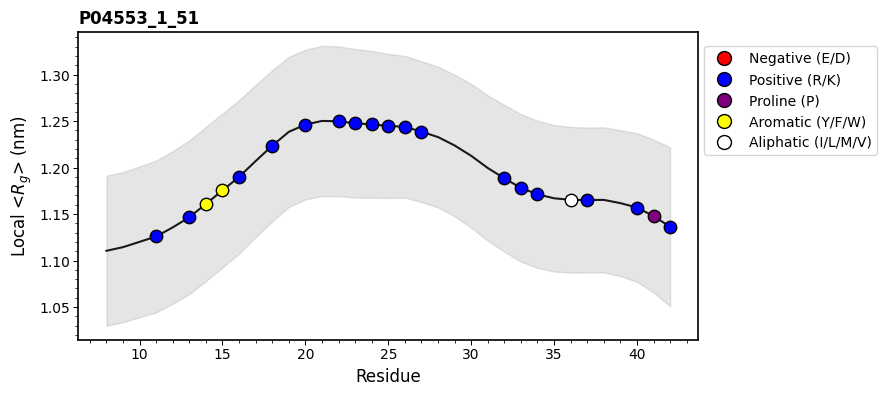

In [26]:
df = p1.copy()  # Assuming p1 is defined elsewhere and has the necessary data
print('uses stdev/2')

# Calculate the midpoint for plotting and the properties for each midpoint
df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]), axis=1, result_type='expand')

# Group by 'mid_residue' to calculate mean, standard deviation and get the most common color and size
stats_rg = df.groupby('mid_residue').agg({
    'Rg/nm': ['mean', 'std'],
    'color': lambda x: x.mode()[0],
    'size': lambda x: x.mode()[0]
}).reset_index()

# Flatten the MultiIndex
stats_rg.columns = ['mid_residue', 'mean', 'std', 'color', 'size']

fig, ax = plt.subplots(figsize=(8, 4))

# Plotting
ax.plot(stats_rg['mid_residue'], stats_rg['mean'], color='black', zorder=1)
ax.fill_between(stats_rg['mid_residue'], 
                 stats_rg['mean'] - (stats_rg['std']/2), 
                 stats_rg['mean'] + (stats_rg['std']/2), 
                 color='gray', alpha=0.2, zorder=1)

# Adjust scatter plot to use different sizes and colors with higher zorder
for i, row in stats_rg.iterrows():
    ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)

ax.set_xlabel('Residue', fontsize=12)
ax.set_ylabel('Local <$R_g$> (nm)', fontsize=12)
ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')

# Customizing the plot border thickness
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_linewidth(1.2)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
ax.tick_params(axis='both', which='minor', width=0.6)

# Create custom legend with circles and edge color for white patch
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Proline (P)', markersize=10, markerfacecolor='purple',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Aromatic (Y/F/W)', markersize=10, markerfacecolor='yellow',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Aliphatic (I/L/M/V)', markersize=10, markerfacecolor='white',
           markeredgewidth=1, markeredgecolor='black')  
]

# Adding the legend with the custom entries
ax.legend(handles=legend_elements, loc=(1.01,0.6))
del df

In [27]:
ax.get_ylim()

(1.0146962367990164, 1.3460902649151891)

uses minimum and maximum


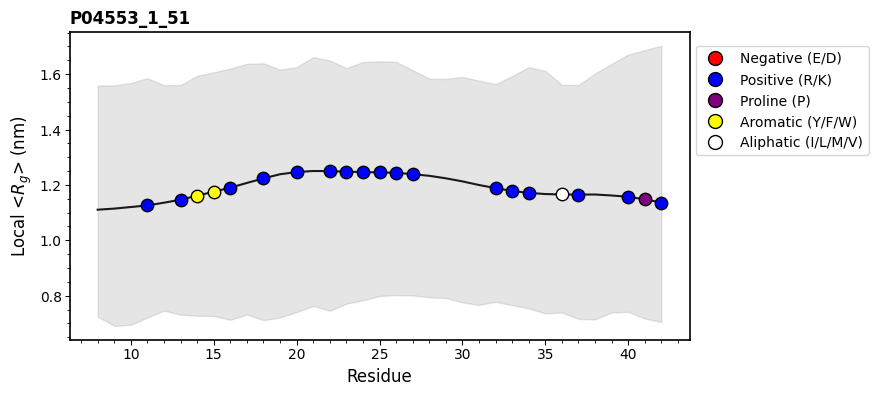

In [24]:
df = p1.copy()  # Assuming p1 is defined elsewhere and has the necessary data
print('uses minimum and maximum')
# Calculate the midpoint for plotting and the properties for each midpoint
df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
df[['color', 'size']] = df.apply(lambda row: assign_properties(row['full_protein_fasta'][row['mid_residue']]), axis=1, result_type='expand')

# Group by 'mid_residue' to calculate mean, min max and get the most common color and size
stats_rg = df.groupby('mid_residue').agg({
    'Rg/nm': ['mean', 'min','max'],
    'color': lambda x: x.mode()[0],
    'size': lambda x: x.mode()[0]
}).reset_index()

# Flatten the MultiIndex
stats_rg.columns = ['mid_residue', 'mean', 'min','max', 'color', 'size']

fig, ax = plt.subplots(figsize=(8, 4))

# Plotting
ax.plot(stats_rg['mid_residue'], stats_rg['mean'], color='black', zorder=1)
ax.fill_between(stats_rg['mid_residue'], 
                 stats_rg['min'], 
                 stats_rg['max'], 
                 color='gray', alpha=0.2, zorder=1)

# Adjust scatter plot to use different sizes and colors with higher zorder
for i, row in stats_rg.iterrows():
    ax.scatter(row['mid_residue'], row['mean'], color=row['color'], s=row['size'], zorder=2,edgecolors='black', linewidths=1)

ax.set_xlabel('Residue', fontsize=12)
ax.set_ylabel('Local <$R_g$> (nm)', fontsize=12)
ax.set_title(df.seq_name.unique()[0], loc='left', fontsize=12, fontweight='bold')

# Customizing the plot border thickness
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_linewidth(1.2)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=10, width=0.75, pad=2)
ax.tick_params(axis='both', which='minor', width=0.6)

# Create custom legend with circles and edge color for white patch
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Negative (E/D)', markersize=10, markerfacecolor='red',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Positive (R/K)', markersize=10, markerfacecolor='blue',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Proline (P)', markersize=10, markerfacecolor='purple',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Aromatic (Y/F/W)', markersize=10, markerfacecolor='yellow',
          markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Aliphatic (I/L/M/V)', markersize=10, markerfacecolor='white',
           markeredgewidth=1, markeredgecolor='black')  
]

# Adding the legend with the custom entries
ax.legend(handles=legend_elements, loc=(1.01,0.6))
del df

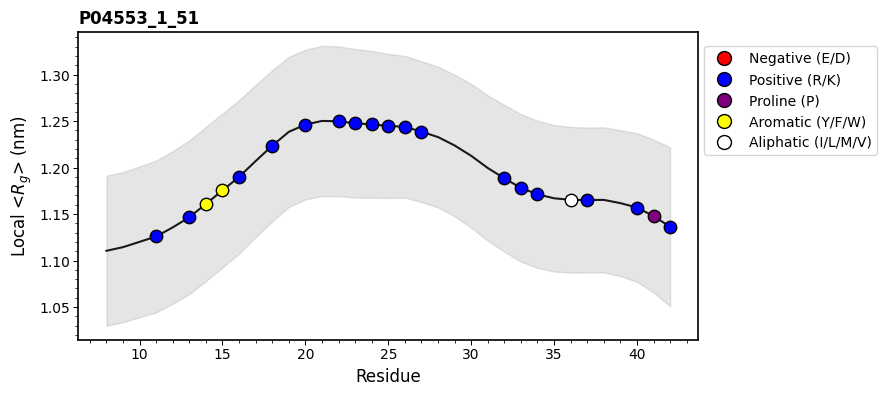

In [33]:
subchain_Rg_plot(p1,8,4)

CPU times: user 5min 49s, sys: 6.78 s, total: 5min 55s
Wall time: 5min 56s


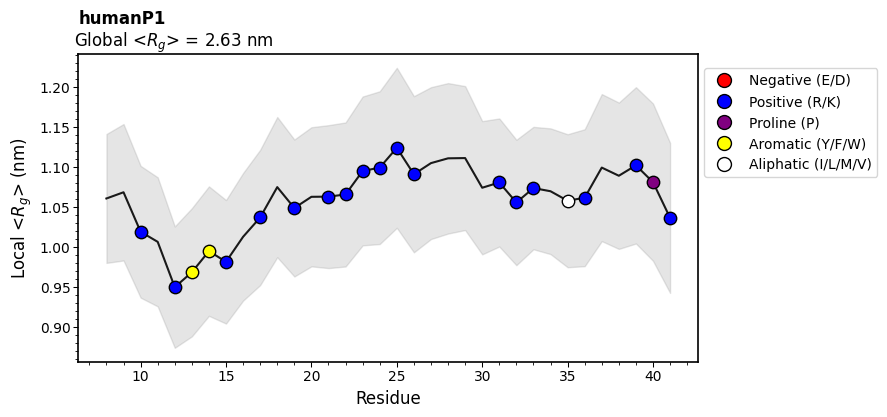

In [91]:
%%time
subchain_Rg_plot(human_P1_allatom,8,4)

In [95]:
human_P1_allatom

,fasta_sequence,start_res_zeroindex,end_res_zeroindex,full_protein_fasta,full_protein_rgyr,full_protein_inst_ratio,full_protein_RSA,full_protein_rg_rg_theta_mean,sim,seq_name,Rg/nm,ete,inst_ratio,RSA,AFRC_mean_rg_theta,rg_rg_theta_mean,mid_residue,color,size
0,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.929137,2.306567,6.162717,0.363755,10.383179,0.894849,8,black,0
1,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.918574,2.320852,6.383616,0.355941,10.383179,0.884675,8,black,0
2,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.910422,2.213886,5.913234,0.336007,10.383179,0.876824,8,black,0
3,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.908483,2.204199,5.886646,0.334319,10.383179,0.874956,8,black,0
4,ARYRCCRSQSRSRYYRQ,0,16,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.625068,6.798465,0.757238,1.475295,first,humanP1,0.920208,2.153309,5.475709,0.364707,10.383179,0.886249,8,black,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17679995,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.939707,1.570015,2.791406,0.277304,10.376373,0.905622,41,blue,80
17679996,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.923646,1.559126,2.849387,0.250496,10.376373,0.890143,41,blue,80
17679997,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.946069,1.590225,2.825346,0.299599,10.376373,0.911753,41,blue,80
17679998,RAMRCCRPRYRPRCRRH,33,49,ARYRCCRSQSRSRYYRQRQRSRRRRRRSCQTRRRAMRCCRPRYRPR...,2.175474,7.613967,0.735950,1.222622,fourteenth,humanP1,0.956654,1.579043,2.724448,0.301497,10.376373,0.921954,41,blue,80


CPU times: user 5min 42s, sys: 14.8 s, total: 5min 57s
Wall time: 5min 57s


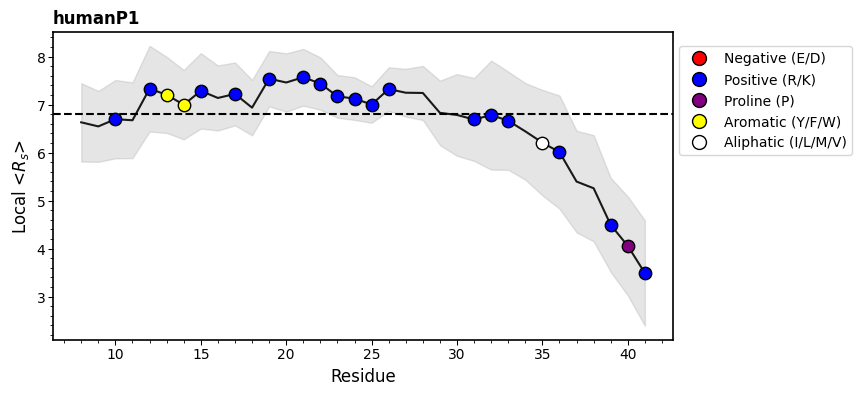

In [98]:
%%time
subchain_Rs_plot(human_P1_allatom,8,4)

CPU times: user 5min 43s, sys: 6.25 s, total: 5min 49s
Wall time: 5min 49s


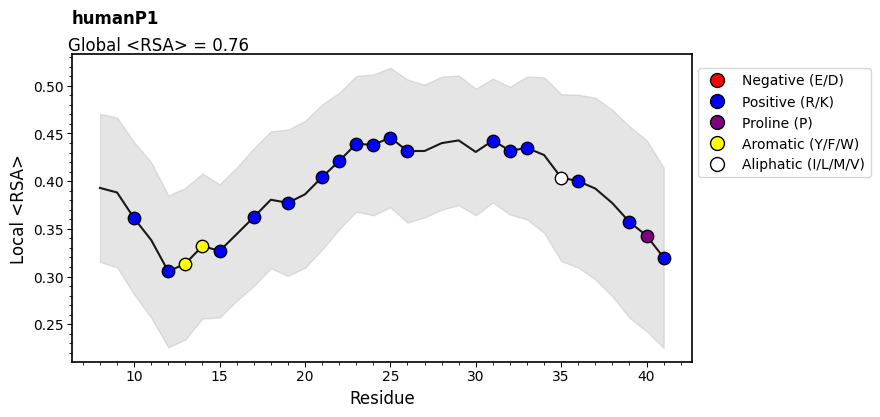

In [99]:
%%time
subchain_RSA_plot(human_P1_allatom,8,4)

CPU times: user 5min 46s, sys: 6.1 s, total: 5min 52s
Wall time: 5min 53s


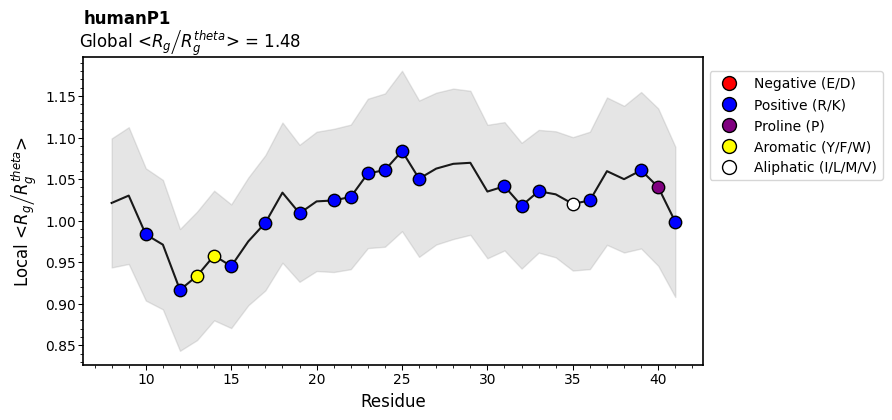

In [100]:
%%time
subchain_Rg_Rg_theta_mean_plot(human_P1_allatom,8,4)

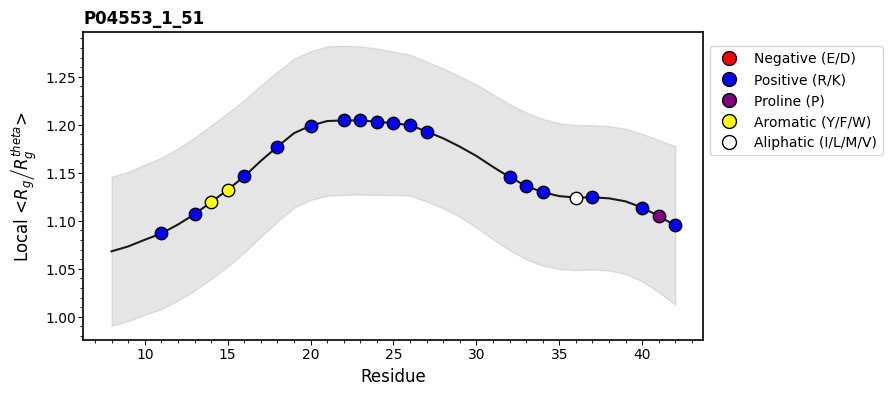

In [28]:
subchain_Rg_Rg_theta_mean_plot(p1)

In [30]:
p1.AFRC_mean_rg_theta.unique()

array([10.39593626, 10.38317893, 10.3693568 , 10.35994348, 10.36125595,
       10.35885   , 10.37023331, 10.38164135, 10.38405776, 10.39351439,
       10.38449722, 10.37505677, 10.35841268, 10.35972477, 10.36913769,
       10.38295925, 10.39571604, 10.38669511, 10.37527612, 10.36782325,
       10.36650913, 10.36147473, 10.37286374, 10.3708908 , 10.38889391,
       10.37637302])

# get subchain heatmap

## checking human P1 all atom simulation subchain heatmap

residue 0 to 16


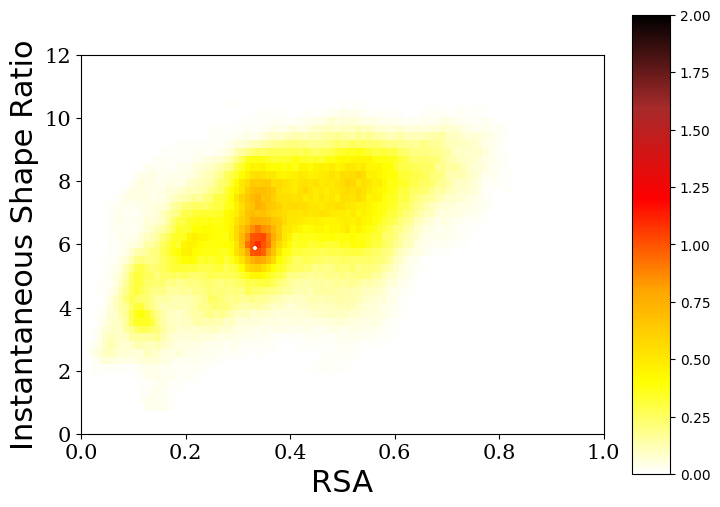

In [26]:
df = human_P1_allatom[ (human_P1_allatom.start_res_zeroindex>=0) & (human_P1_allatom.end_res_zeroindex<=16)].copy()
print('residue 0 to 16')

# rg_by_rg_mean = []
# for mid_res in df['mid_residue'].unique():
#     rg_mean = df[df.mid_residue==mid_res]['Rg/nm'].mean()
#     rg_by_rg_mean.append(df[df.mid_residue==mid_res]['Rg/nm'].values/rg_mean)

# df['Rg/Rg_mean'] = np.concatenate(rg_by_rg_mean)
# del rg_by_rg_mean

#heatmap start

# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"


x = df['RSA']
y = df['inst_ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,12]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
#H = gaussian_filter(H,sigma=3)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
       interpolation='nearest', origin='lower',aspect=aspectratio,vmin=0,vmax=2))
axTemperature.scatter(yedges[np.where(H==np.max(H))[1][0]],xedges[np.where(H==np.max(H))[0][0]],
                   marker='+',color='white',
                  s=10)
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
#Plot the histograms
#ONLY epas=0 data HERE  

# axHistx.hist([testeq_RW[x_variable].values,
#              testeq_RW[x_variable].values,
#              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
#              label=['RW: All Chain Lengths',
#                    'RW: All Chain Lengths',
#                    'salmon'],density=True)


#axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
#            label='GW',alpha=0.5,density=True)

#axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
#            label='GW',orientation='horizontal',alpha=0.5,density=True)

#axHistx.legend()
#axHisty.legend()

#axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
 
    
    
#Set up the histogram limits
#axHistx.set_xlim( min(x), max(x) )
#axHisty.set_ylim( min(y), max(y) )

# axHistx.set_xlim( 1,1.8)
# axHisty.set_ylim( ylims )

 
#Make the tickmarks pretty
# ticklabels = axHistx.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')

# #Make the tickmarks pretty    
# ticklabels = axHistx.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')    
 
# #Make the tickmarks pretty
# ticklabels = axHisty.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
# #Make the tickmarks pretty
# ticklabels = axHisty.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
    
 
#Cool trick that changes the number of tickmarks for the histogram axes
# axHisty.xaxis.set_major_locator(MaxNLocator(4))
# axHistx.yaxis.set_major_locator(MaxNLocator(4))

# axHistx.axes.get_xaxis().set_visible(False)
# axHisty.axes.get_yaxis().set_visible(False)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')

del df

residue 15 to 33


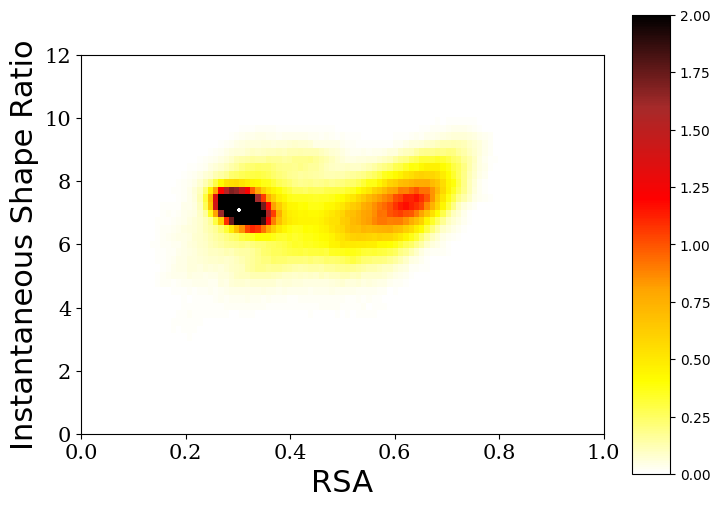

In [27]:
df = human_P1_allatom[ (human_P1_allatom.start_res_zeroindex>14) & (human_P1_allatom.end_res_zeroindex<=33)].copy()
print('residue 15 to 33')

# rg_by_rg_mean = []
# for mid_res in df['mid_residue'].unique():
#     rg_mean = df[df.mid_residue==mid_res]['Rg/nm'].mean()
#     rg_by_rg_mean.append(df[df.mid_residue==mid_res]['Rg/nm'].values/rg_mean)

# df['Rg/Rg_mean'] = np.concatenate(rg_by_rg_mean)
# del rg_by_rg_mean

#heatmap start

# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"


x = df['RSA']
y = df['inst_ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,12]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
#H = gaussian_filter(H,sigma=3)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
       interpolation='nearest', origin='lower',aspect=aspectratio,vmin=0,vmax=2))
axTemperature.scatter(yedges[np.where(H==np.max(H))[1][0]],xedges[np.where(H==np.max(H))[0][0]],
                   marker='+',color='white',
                  s=10)
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
#Plot the histograms
#ONLY epas=0 data HERE  

# axHistx.hist([testeq_RW[x_variable].values,
#              testeq_RW[x_variable].values,
#              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
#              label=['RW: All Chain Lengths',
#                    'RW: All Chain Lengths',
#                    'salmon'],density=True)


#axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
#            label='GW',alpha=0.5,density=True)

#axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
#            label='GW',orientation='horizontal',alpha=0.5,density=True)

#axHistx.legend()
#axHisty.legend()

#axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
 
    
    
#Set up the histogram limits
#axHistx.set_xlim( min(x), max(x) )
#axHisty.set_ylim( min(y), max(y) )

# axHistx.set_xlim( 1,1.8)
# axHisty.set_ylim( ylims )

 
#Make the tickmarks pretty
# ticklabels = axHistx.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')

# #Make the tickmarks pretty    
# ticklabels = axHistx.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')    
 
# #Make the tickmarks pretty
# ticklabels = axHisty.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
# #Make the tickmarks pretty
# ticklabels = axHisty.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
    
 
#Cool trick that changes the number of tickmarks for the histogram axes
# axHisty.xaxis.set_major_locator(MaxNLocator(4))
# axHistx.yaxis.set_major_locator(MaxNLocator(4))

# axHistx.axes.get_xaxis().set_visible(False)
# axHisty.axes.get_yaxis().set_visible(False)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')

del df

residue 33 to 49


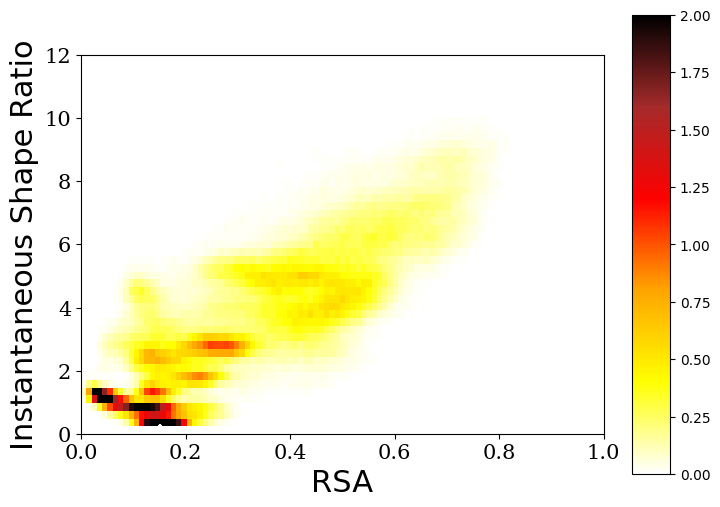

In [28]:
df = human_P1_allatom[ (human_P1_allatom.start_res_zeroindex>=33) & (human_P1_allatom.end_res_zeroindex<=49)].copy()
print('residue 33 to 49')

# rg_by_rg_mean = []
# for mid_res in df['mid_residue'].unique():
#     rg_mean = df[df.mid_residue==mid_res]['Rg/nm'].mean()
#     rg_by_rg_mean.append(df[df.mid_residue==mid_res]['Rg/nm'].values/rg_mean)

# df['Rg/Rg_mean'] = np.concatenate(rg_by_rg_mean)
# del rg_by_rg_mean

#heatmap start

# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"


x = df['RSA']
y = df['inst_ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,12]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
#H = gaussian_filter(H,sigma=3)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
       interpolation='nearest', origin='lower',aspect=aspectratio,vmin=0,vmax=2))
axTemperature.scatter(yedges[np.where(H==np.max(H))[1][0]],xedges[np.where(H==np.max(H))[0][0]],
                   marker='+',color='white',
                  s=10)
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
#Plot the histograms
#ONLY epas=0 data HERE  

# axHistx.hist([testeq_RW[x_variable].values,
#              testeq_RW[x_variable].values,
#              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
#              label=['RW: All Chain Lengths',
#                    'RW: All Chain Lengths',
#                    'salmon'],density=True)


#axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
#            label='GW',alpha=0.5,density=True)

#axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
#            label='GW',orientation='horizontal',alpha=0.5,density=True)

#axHistx.legend()
#axHisty.legend()

#axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
 
    
    
#Set up the histogram limits
#axHistx.set_xlim( min(x), max(x) )
#axHisty.set_ylim( min(y), max(y) )

# axHistx.set_xlim( 1,1.8)
# axHisty.set_ylim( ylims )

 
#Make the tickmarks pretty
# ticklabels = axHistx.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')

# #Make the tickmarks pretty    
# ticklabels = axHistx.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')    
 
# #Make the tickmarks pretty
# ticklabels = axHisty.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
# #Make the tickmarks pretty
# ticklabels = axHisty.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
    
 
#Cool trick that changes the number of tickmarks for the histogram axes
# axHisty.xaxis.set_major_locator(MaxNLocator(4))
# axHistx.yaxis.set_major_locator(MaxNLocator(4))

# axHistx.axes.get_xaxis().set_visible(False)
# axHisty.axes.get_yaxis().set_visible(False)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')

del df

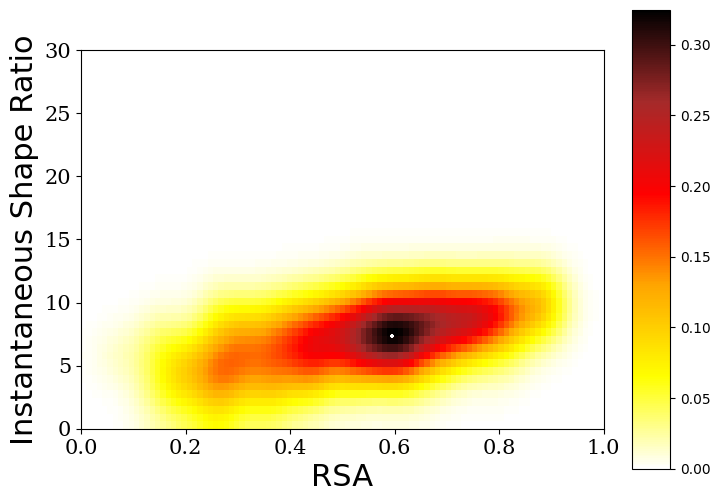

In [55]:
df = p1.copy()


df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
choose_mid_residue = 8
rg_by_rg_mean = []
for mid_res in df['mid_residue'].unique():
    rg_mean = df[df.mid_residue==mid_res]['Rg/nm'].mean()
    rg_by_rg_mean.append(df[df.mid_residue==mid_res]['Rg/nm'].values/rg_mean)

df['Rg/Rg_mean'] = np.concatenate(rg_by_rg_mean)
del rg_by_rg_mean

#heatmap start

# Define the x and y data 
# For example just using random numbers
#ORDER is RW->RW->salmon
#ONLY epas=0 data here
x_variable='RSA'
y_variable="Instantaneous Shape Ratio"


x = df[df.mid_residue==choose_mid_residue]['RSA']
y = df[df.mid_residue==choose_mid_residue]['inst_ratio']

 
# Set up default x and y limits
xlims = [0,1]
ylims = [0,30]
 
# Set up your x and y labels
xlabel = x_variable
ylabel = y_variable
 


left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width

rect_temperature = [left, bottom, width, height] # dimensions of temp plot
#rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
#rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram

 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axTemperature = plt.axes(rect_temperature) # temperature plot
#axHistx = plt.axes(rect_histx) # x histogram
#axHisty = plt.axes(rect_histy) # y histogram
 
# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)
 
# Find the min/max of the data
xmin = min(xlims)
xmax = max(xlims)
ymin = min(ylims)
ymax = max(ylims)
 
# Make the 'main' temperature plot
# Define the number of bins
nxbins = 100
nybins = 50
nbins = nxbins+nybins
 
xbins = linspace(start = xmin, stop = xmax, num = nxbins)
ybins = linspace(start = ymin, stop = ymax, num = nybins)
xcenter = (xbins[0:-1]+xbins[1:])/2.0
ycenter = (ybins[0:-1]+ybins[1:])/2.0
aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
 
H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
X = xcenter
Y = ycenter
Z = H
 
H = gaussian_filter(H,sigma=3)    
palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])
# Plot the temperature data
cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
       interpolation='nearest', origin='lower',aspect=aspectratio))
axTemperature.scatter(yedges[np.where(H==np.max(H))[1][0]],xedges[np.where(H==np.max(H))[0][0]],
                   marker='+',color='white',
                  s=10)
 
#Plot the axes labels
axTemperature.set_xlabel(xlabel,fontsize=22)
axTemperature.set_ylabel(ylabel,fontsize=22)
 
#Make the tickmarks pretty
ticklabels = axTemperature.get_xticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
ticklabels = axTemperature.get_yticklabels()
for label in ticklabels:
    label.set_fontsize(15)
    label.set_family('serif')
 
#Set up the plot limits
axTemperature.set_xlim(xlims)
axTemperature.set_ylim(ylims)
 
#Set up the histogram bins
xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
 
#Plot the histograms
#ONLY epas=0 data HERE  

# axHistx.hist([testeq_RW[x_variable].values,
#              testeq_RW[x_variable].values,
#              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
#              label=['RW: All Chain Lengths',
#                    'RW: All Chain Lengths',
#                    'salmon'],density=True)


#axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
#            label='GW',alpha=0.5,density=True)

#axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
#            label='GW',orientation='horizontal',alpha=0.5,density=True)

#axHistx.legend()
#axHisty.legend()

#axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
 
    
    
#Set up the histogram limits
#axHistx.set_xlim( min(x), max(x) )
#axHisty.set_ylim( min(y), max(y) )

# axHistx.set_xlim( 1,1.8)
# axHisty.set_ylim( ylims )

 
#Make the tickmarks pretty
# ticklabels = axHistx.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')

# #Make the tickmarks pretty    
# ticklabels = axHistx.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')    
 
# #Make the tickmarks pretty
# ticklabels = axHisty.get_xticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
# #Make the tickmarks pretty
# ticklabels = axHisty.get_yticklabels()
# for label in ticklabels:
#     label.set_fontsize(12)
#     label.set_family('serif')
    
 
#Cool trick that changes the number of tickmarks for the histogram axes
# axHisty.xaxis.set_major_locator(MaxNLocator(4))
# axHistx.yaxis.set_major_locator(MaxNLocator(4))

# axHistx.axes.get_xaxis().set_visible(False)
# axHisty.axes.get_yaxis().set_visible(False)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)    
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
fig.colorbar(cax, cax=cbar_ax,
             format=ticker.FuncFormatter(myfmt))

#Show the plot
plt.draw()
 
# Save to a File
#filename = 'RW_3d_plot'
#plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')

del df

In [27]:
def plot_heatmap_at_mid_residue(df,choose_mid_residue,x_axis_variable):
    df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
    rg_by_rg_mean = []
    for mid_res in df['mid_residue'].unique():
        rg_mean = df[df.mid_residue==mid_res]['Rg/nm'].mean()
        rg_by_rg_mean.append(df[df.mid_residue==mid_res]['Rg/nm'].values/rg_mean)
    
    df['Rg/Rg_mean'] = np.concatenate(rg_by_rg_mean)
    del rg_by_rg_mean
    
    #heatmap start
    
    # Define the x and y data 
    # For example just using random numbers
    #ORDER is RW->RW->salmon
    #ONLY epas=0 data here
    if x_axis_variable == 'RSA':
        x_variable='RSA'
        y_variable="Instantaneous Shape Ratio"
        
        
        x = df[df.mid_residue==choose_mid_residue]['RSA']
        y = df[df.mid_residue==choose_mid_residue]['inst_ratio']
        
         
        # Set up default x and y limits
        xlims = [0,1]
        ylims = [0,30]
         
        # Set up your x and y labels
        xlabel = x_variable
        ylabel = y_variable
         
        
        
        left, width = 0.12, 0.55
        bottom, height = 0.12, 0.55
        bottom_h = left_h = left+width
        
        rect_temperature = [left, bottom, width, height] # dimensions of temp plot
        #rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
        #rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram
        
         
        # Set up the size of the figure
        fig = plt.figure(1, figsize=(9.5,9))
         
        # Make the three plots
        axTemperature = plt.axes(rect_temperature) # temperature plot
        #axHistx = plt.axes(rect_histx) # x histogram
        #axHisty = plt.axes(rect_histy) # y histogram
         
        # Remove the inner axes numbers of the histograms
        nullfmt = NullFormatter()
        #axHistx.xaxis.set_major_formatter(nullfmt)
        #axHisty.yaxis.set_major_formatter(nullfmt)
         
        # Find the min/max of the data
        xmin = min(xlims)
        xmax = max(xlims)
        ymin = min(ylims)
        ymax = max(ylims)
         
        # Make the 'main' temperature plot
        # Define the number of bins
        nxbins = 100
        nybins = 50
        nbins = nxbins+nybins
         
        xbins = linspace(start = xmin, stop = xmax, num = nxbins)
        ybins = linspace(start = ymin, stop = ymax, num = nybins)
        xcenter = (xbins[0:-1]+xbins[1:])/2.0
        ycenter = (ybins[0:-1]+ybins[1:])/2.0
        aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
         
        H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
        X = xcenter
        Y = ycenter
        Z = H
         
        H = gaussian_filter(H,sigma=3)    
        palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])
        # Plot the temperature data
        cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
               interpolation='nearest', origin='lower',aspect=aspectratio))
        axTemperature.scatter(yedges[np.where(H==np.max(H))[1][0]],xedges[np.where(H==np.max(H))[0][0]],
                           marker='+',color='white',
                          s=10)
         
        #Plot the axes labels
        axTemperature.set_xlabel(xlabel,fontsize=22)
        axTemperature.set_ylabel(ylabel,fontsize=22)
         
        #Make the tickmarks pretty
        ticklabels = axTemperature.get_xticklabels()
        for label in ticklabels:
            label.set_fontsize(15)
            label.set_family('serif')
         
        ticklabels = axTemperature.get_yticklabels()
        for label in ticklabels:
            label.set_fontsize(15)
            label.set_family('serif')
         
        #Set up the plot limits
        axTemperature.set_xlim(xlims)
        axTemperature.set_ylim(ylims)
         
        #Set up the histogram bins
        xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
        ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
         
        #Plot the histograms
        #ONLY epas=0 data HERE  
        
        # axHistx.hist([testeq_RW[x_variable].values,
        #              testeq_RW[x_variable].values,
        #              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
        #              label=['RW: All Chain Lengths',
        #                    'RW: All Chain Lengths',
        #                    'salmon'],density=True)
        
        
        #axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
        #            label='GW',alpha=0.5,density=True)
        
        #axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
        #            label='GW',orientation='horizontal',alpha=0.5,density=True)
        
        #axHistx.legend()
        #axHisty.legend()
        
        #axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
         
            
            
        #Set up the histogram limits
        #axHistx.set_xlim( min(x), max(x) )
        #axHisty.set_ylim( min(y), max(y) )
        
        # axHistx.set_xlim( 1,1.8)
        # axHisty.set_ylim( ylims )
        
         
        #Make the tickmarks pretty
        # ticklabels = axHistx.get_yticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')
        
        # #Make the tickmarks pretty    
        # ticklabels = axHistx.get_xticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')    
         
        # #Make the tickmarks pretty
        # ticklabels = axHisty.get_xticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')
        # #Make the tickmarks pretty
        # ticklabels = axHisty.get_yticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')
            
         
        #Cool trick that changes the number of tickmarks for the histogram axes
        # axHisty.xaxis.set_major_locator(MaxNLocator(4))
        # axHistx.yaxis.set_major_locator(MaxNLocator(4))
        
        # axHistx.axes.get_xaxis().set_visible(False)
        # axHisty.axes.get_yaxis().set_visible(False)
        
        def myfmt(x, pos):
            return '{0:.2f}'.format(x)    
            
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
        fig.colorbar(cax, cax=cbar_ax,
                     format=ticker.FuncFormatter(myfmt))
        
        #Show the plot
        plt.draw()
         
        # Save to a File
        #filename = 'RW_3d_plot'
        #plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')
    elif x_axis_variable == 'Rg/Rg_mean':
        x_variable=r'$R_g\left/R_g^{mean}\right.$'
        y_variable="Instantaneous Shape Ratio"
        
        
        x = df[df.mid_residue==choose_mid_residue]['Rg/Rg_mean']
        y = df[df.mid_residue==choose_mid_residue]['inst_ratio']
        
         
        # Set up default x and y limits
        xlims = [0,3]
        ylims = [0,30]
         
        # Set up your x and y labels
        xlabel = x_variable
        ylabel = y_variable
         
        
        
        left, width = 0.12, 0.55
        bottom, height = 0.12, 0.55
        bottom_h = left_h = left+width
        
        rect_temperature = [left, bottom, width, height] # dimensions of temp plot
        #rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
        #rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram
        
         
        # Set up the size of the figure
        fig = plt.figure(1, figsize=(9.5,9))
         
        # Make the three plots
        axTemperature = plt.axes(rect_temperature) # temperature plot
        #axHistx = plt.axes(rect_histx) # x histogram
        #axHisty = plt.axes(rect_histy) # y histogram
         
        # Remove the inner axes numbers of the histograms
        nullfmt = NullFormatter()
        #axHistx.xaxis.set_major_formatter(nullfmt)
        #axHisty.yaxis.set_major_formatter(nullfmt)
         
        # Find the min/max of the data
        xmin = min(xlims)
        xmax = max(xlims)
        ymin = min(ylims)
        ymax = max(ylims)
         
        # Make the 'main' temperature plot
        # Define the number of bins
        nxbins = 100
        nybins = 50
        nbins = nxbins+nybins
         
        xbins = linspace(start = xmin, stop = xmax, num = nxbins)
        ybins = linspace(start = ymin, stop = ymax, num = nybins)
        xcenter = (xbins[0:-1]+xbins[1:])/2.0
        ycenter = (ybins[0:-1]+ybins[1:])/2.0
        aspectratio = (1.0*(xmax - 0))/(1.38*ymax - 0)
         
        H, xedges,yedges = np.histogram2d(y,x,bins=(ybins,xbins),density=True)
        X = xcenter
        Y = ycenter
        Z = H
         
        H = gaussian_filter(H,sigma=3)    
        palette = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",'yellow',"orange",'red',"brown",'black'])
        # Plot the temperature data
        cax = (axTemperature.imshow(H, extent=[xmin,xmax,ymin,ymax],cmap=palette,
               interpolation='nearest', origin='lower',aspect=aspectratio))
        axTemperature.scatter(yedges[np.where(H==np.max(H))[1][0]],xedges[np.where(H==np.max(H))[0][0]],
                           marker='+',color='white',
                          s=10)
         
        #Plot the axes labels
        axTemperature.set_xlabel(xlabel,fontsize=22)
        axTemperature.set_ylabel(ylabel,fontsize=22)
         
        #Make the tickmarks pretty
        ticklabels = axTemperature.get_xticklabels()
        for label in ticklabels:
            label.set_fontsize(15)
            label.set_family('serif')
         
        ticklabels = axTemperature.get_yticklabels()
        for label in ticklabels:
            label.set_fontsize(15)
            label.set_family('serif')
         
        #Set up the plot limits
        axTemperature.set_xlim(xlims)
        axTemperature.set_ylim(ylims)
         
        #Set up the histogram bins
        xbins = np.arange(xmin, xmax, (xmax-xmin)/nbins)
        ybins = np.arange(ymin, ymax, (ymax-ymin)/nbins)
         
        #Plot the histograms
        #ONLY epas=0 data HERE  
        
        # axHistx.hist([testeq_RW[x_variable].values,
        #              testeq_RW[x_variable].values,
        #              temp_sal[x_variable].values], bins=xbins, color = ['blue','green','purple'],
        #              label=['RW: All Chain Lengths',
        #                    'RW: All Chain Lengths',
        #                    'salmon'],density=True)
        
        
        #axHistx.hist(GW_ref_for_3d['Rg/Rg_mean'].values, bins=xbins, color = 'green',
        #            label='GW',alpha=0.5,density=True)
        
        #axHisty.hist(GW_ref_for_3d['ratio'].values, bins=ybins, color = 'green',
        #            label='GW',orientation='horizontal',alpha=0.5,density=True)
        
        #axHistx.legend()
        #axHisty.legend()
        
        #axHisty.hist(y, bins=ybins, orientation='horizontal', color = 'red')
         
            
            
        #Set up the histogram limits
        #axHistx.set_xlim( min(x), max(x) )
        #axHisty.set_ylim( min(y), max(y) )
        
        # axHistx.set_xlim( 1,1.8)
        # axHisty.set_ylim( ylims )
        
         
        #Make the tickmarks pretty
        # ticklabels = axHistx.get_yticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')
        
        # #Make the tickmarks pretty    
        # ticklabels = axHistx.get_xticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')    
         
        # #Make the tickmarks pretty
        # ticklabels = axHisty.get_xticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')
        # #Make the tickmarks pretty
        # ticklabels = axHisty.get_yticklabels()
        # for label in ticklabels:
        #     label.set_fontsize(12)
        #     label.set_family('serif')
            
         
        #Cool trick that changes the number of tickmarks for the histogram axes
        # axHisty.xaxis.set_major_locator(MaxNLocator(4))
        # axHistx.yaxis.set_major_locator(MaxNLocator(4))
        
        # axHistx.axes.get_xaxis().set_visible(False)
        # axHisty.axes.get_yaxis().set_visible(False)
        
        def myfmt(x, pos):
            return '{0:.2f}'.format(x)    
            
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.7, 0.14, 0.04, 0.51])
        fig.colorbar(cax, cax=cbar_ax,
                     format=ticker.FuncFormatter(myfmt))
        
        #Show the plot
        plt.draw()
         
        # Save to a File
        #filename = 'RW_3d_plot'
        #plt.savefig(filename + '.png',dpi=800,bbox_inches='tight')
        

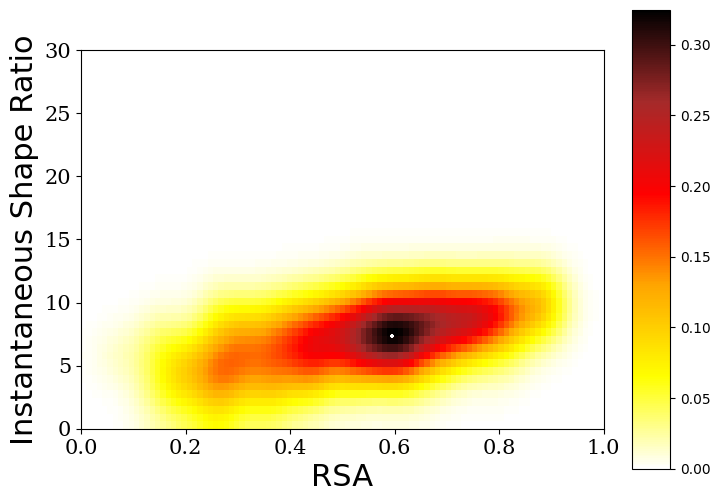

In [33]:
plot_heatmap_at_mid_residue(p1,8,'RSA')

In [41]:
def plot_peak_y_variable(df,x_axis_variable):
    #X and Y refer to different things here watch out, 
    #there is x and y for histogram2d and x and y for plot
    fig,ax = plt.subplots(figsize=(6,4))
    if x_axis_variable=='Rg/Rg_mean':
        df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
        rg_by_rg_mean = []
        for mid_res in df['mid_residue'].unique():
            rg_mean = df[df.mid_residue==mid_res]['Rg/nm'].mean()
            rg_by_rg_mean.append(df[df.mid_residue==mid_res]['Rg/nm'].values/rg_mean)
        
        df['Rg/Rg_mean'] = np.concatenate(rg_by_rg_mean)
        del rg_by_rg_mean
        
        
        max_value_x=3#change here if needed
        max_value_y=30
        xlims = [0,max_value_x]
        ylims = [0,max_value_y]
        x_for_plot = []
        y_for_plot = []
        
        for mid_res in df.mid_residue.unique():
            x_considered=df[df.mid_residue==mid_res]['Rg/Rg_mean'].values#change here if needed 
            y_considered=df[df.mid_residue==mid_res].inst_ratio.values
            
            xmin = min(xlims)
            xmax = max(xlims)
            ymin = min(ylims)
            ymax = max(ylims)
            nxbins = 100
            nybins = 50
            nbins = nxbins+nybins
             
            xbins = linspace(start = xmin, stop = xmax, num = nxbins)
            ybins = linspace(start = ymin, stop = ymax, num = nybins)
            
            H, xedges,yedges = np.histogram2d(y_considered,x_considered,bins=(ybins,xbins),density=True)
            
            x_peak_coor = yedges[np.where(H==np.max(H))[1][0]]
            y_peak_coor = xedges[np.where(H==np.max(H))[0][0]]
        
            x_for_plot.append(mid_res)
            y_for_plot.append(x_peak_coor)#change here the peak_coor variable
            ax.scatter(mid_res, x_peak_coor,s=15,color='red')#change here the peak_coor variable
            
            plt.setp(ax.get_yticklabels(), fontsize=12)
            plt.setp(ax.get_xticklabels(), fontsize=12)
            for i in ['top', 'left', 'right', 'bottom']:
                ax.spines[i].set_linewidth(1)
            ax.minorticks_on()
            ax.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad=2)
            ax.tick_params(axis='both', which='minor', width = 0.6) 
            
            ax.set_ylabel(r'Peak: $R_g\left/R_g^{mean}\right.$',fontsize=14,labelpad=1)
            ax.set_xlabel('Mid Residue',fontsize=14,labelpad=1)
        ax.plot(x_for_plot, y_for_plot,color='red')    
    elif x_axis_variable == 'RSA':
        df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
        
        max_value_x=1#change here if needed
        max_value_y=30
        xlims = [0,max_value_x]
        ylims = [0,max_value_y]
        x_for_plot = []
        y_for_plot = []
        
        for mid_res in df.mid_residue.unique():
            x_considered=df[df.mid_residue==mid_res]['RSA'].values#change here if needed 
            y_considered=df[df.mid_residue==mid_res].inst_ratio.values
            
            xmin = min(xlims)
            xmax = max(xlims)
            ymin = min(ylims)
            ymax = max(ylims)
            nxbins = 100
            nybins = 50
            nbins = nxbins+nybins
             
            xbins = linspace(start = xmin, stop = xmax, num = nxbins)
            ybins = linspace(start = ymin, stop = ymax, num = nybins)
            
            H, xedges,yedges = np.histogram2d(y_considered,x_considered,bins=(ybins,xbins),density=True)
            
            x_peak_coor = yedges[np.where(H==np.max(H))[1][0]]
            y_peak_coor = xedges[np.where(H==np.max(H))[0][0]]
        
            x_for_plot.append(mid_res)
            y_for_plot.append(x_peak_coor)#change here the peak_coor variable
            ax.scatter(mid_res, x_peak_coor,s=15,color='red')#change here the peak_coor variable
            
            plt.setp(ax.get_yticklabels(), fontsize=12)
            plt.setp(ax.get_xticklabels(), fontsize=12)
            for i in ['top', 'left', 'right', 'bottom']:
                ax.spines[i].set_linewidth(1)
            ax.minorticks_on()
            ax.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad=2)
            ax.tick_params(axis='both', which='minor', width = 0.6) 
            
            ax.set_ylabel('Peak: RSA',fontsize=14,labelpad=1)
            ax.set_xlabel('Mid Residue',fontsize=14,labelpad=1)
        ax.plot(x_for_plot, y_for_plot,color='red')
    elif x_axis_variable == 'Rs':
            df['mid_residue'] = (df['start_res_zeroindex'] + df['end_res_zeroindex']) // 2
            
            max_value_x=1#change here if needed
            max_value_y=30
            xlims = [0,max_value_x]
            ylims = [0,max_value_y]
            x_for_plot = []
            y_for_plot = []
            
            for mid_res in df.mid_residue.unique():
                x_considered=df[df.mid_residue==mid_res]['RSA'].values#change here if needed 
                y_considered=df[df.mid_residue==mid_res].inst_ratio.values
                
                xmin = min(xlims)
                xmax = max(xlims)
                ymin = min(ylims)
                ymax = max(ylims)
                nxbins = 100
                nybins = 50
                nbins = nxbins+nybins
                 
                xbins = linspace(start = xmin, stop = xmax, num = nxbins)
                ybins = linspace(start = ymin, stop = ymax, num = nybins)
                
                H, xedges,yedges = np.histogram2d(y_considered,x_considered,bins=(ybins,xbins),density=True)
                
                x_peak_coor = yedges[np.where(H==np.max(H))[1][0]]
                y_peak_coor = xedges[np.where(H==np.max(H))[0][0]]
            
                x_for_plot.append(mid_res)
                y_for_plot.append(y_peak_coor)#change here the peak_coor variable
                ax.scatter(mid_res, y_peak_coor,s=15,color='red')#change here the peak_coor variable
                
                plt.setp(ax.get_yticklabels(), fontsize=12)
                plt.setp(ax.get_xticklabels(), fontsize=12)
                for i in ['top', 'left', 'right', 'bottom']:
                    ax.spines[i].set_linewidth(1)
                ax.minorticks_on()
                ax.tick_params(axis='both', which='major', labelsize=10, width = 0.8, pad=2)
                ax.tick_params(axis='both', which='minor', width = 0.6) 
                
                ax.set_ylabel(r'Peak: $R_s$',fontsize=14,labelpad=1)
                ax.set_xlabel('Mid Residue',fontsize=14,labelpad=1)
            ax.plot(x_for_plot, y_for_plot,color='red')        


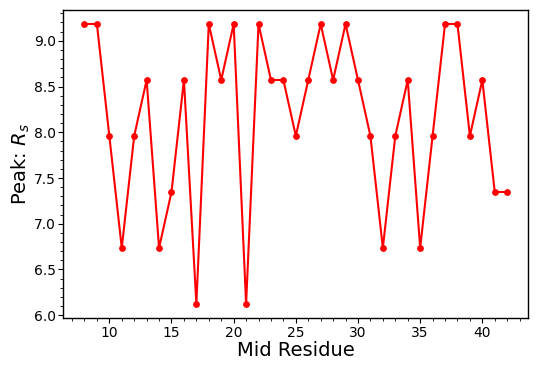

In [42]:
plot_peak_y_variable(p1,'Rs')

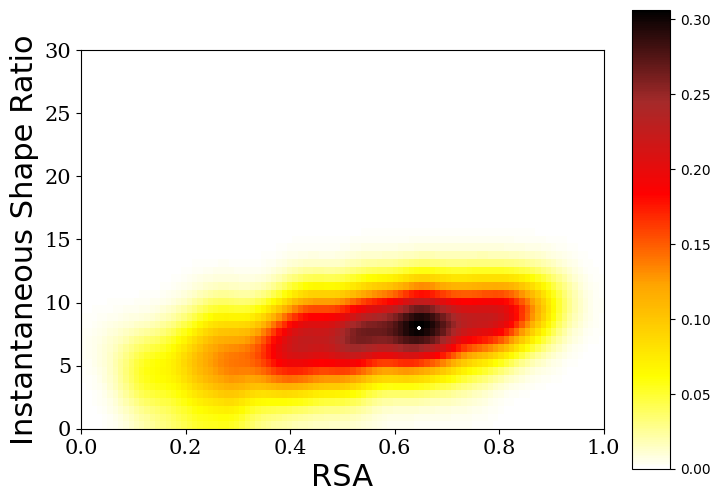

In [44]:
plot_heatmap_at_mid_residue(p1,9,'RSA')

# trying other proteins (not human P1)

In [48]:
idrome_prop_flucs[idrome_prop_flucs.seq_name=='Q9UPT8_1_401']['net_charge']

26931   -0.009975
Name: net_charge, dtype: float64

In [70]:
random_protein = compute_kmer_data_from_seq_name('Q9UPT8_1_401',3)
#idrome_prop_flucs.sort_values(by='nu')

residue 0 to 133 done
residue 1 to 134 done
residue 2 to 135 done
residue 3 to 136 done
residue 4 to 137 done
residue 5 to 138 done
residue 6 to 139 done
residue 7 to 140 done
residue 8 to 141 done
residue 9 to 142 done
residue 10 to 143 done
residue 11 to 144 done
residue 12 to 145 done
residue 13 to 146 done
residue 14 to 147 done
residue 15 to 148 done
residue 16 to 149 done
residue 17 to 150 done
residue 18 to 151 done
residue 19 to 152 done
residue 20 to 153 done
residue 21 to 154 done
residue 22 to 155 done
residue 23 to 156 done
residue 24 to 157 done
residue 25 to 158 done
residue 26 to 159 done
residue 27 to 160 done
residue 28 to 161 done
residue 29 to 162 done
residue 30 to 163 done
residue 31 to 164 done
residue 32 to 165 done
residue 33 to 166 done
residue 34 to 167 done
residue 35 to 168 done
residue 36 to 169 done
residue 37 to 170 done
residue 38 to 171 done
residue 39 to 172 done
residue 40 to 173 done
residue 41 to 174 done
residue 42 to 175 done
residue 43 to 176 don

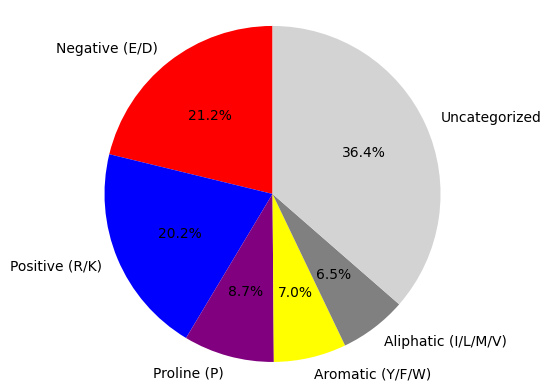

In [136]:
plot_protein_composition('Q9UPT8_1_401')

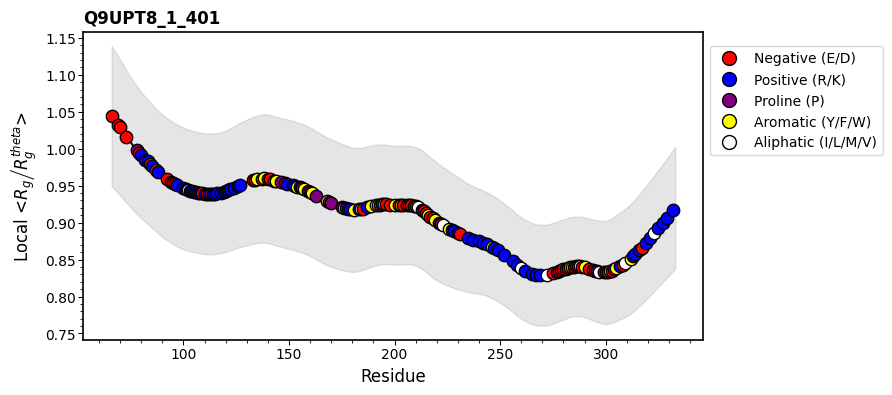

In [72]:
subchain_Rg_Rg_theta_mean_plot(random_protein,8,4)

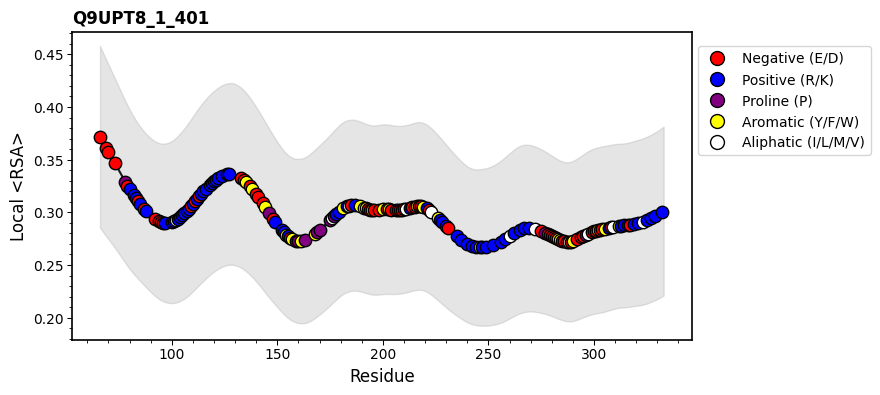

In [60]:
subchain_RSA_plot(random_protein,8,4)

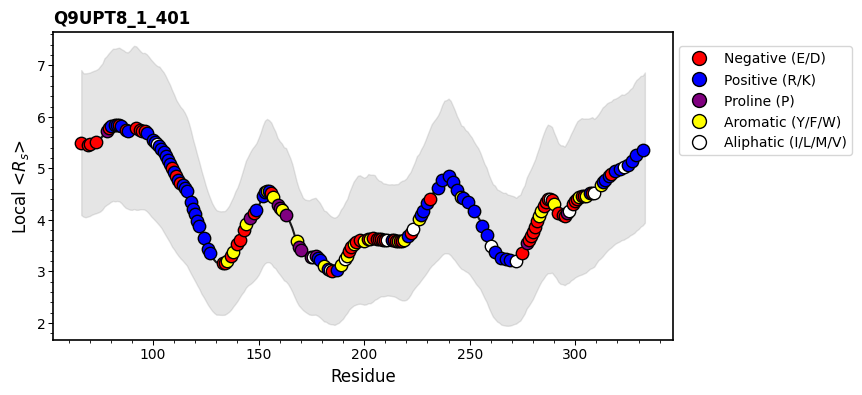

In [61]:
subchain_Rs_plot(random_protein,8,4)

In [90]:
random_protein = compute_kmer_data_from_seq_name('Q96QF7_1_488',3)
#idrome_prop_flucs.sort_values(by='nu')

residue 0 to 162 done
residue 1 to 163 done
residue 2 to 164 done
residue 3 to 165 done
residue 4 to 166 done
residue 5 to 167 done
residue 6 to 168 done
residue 7 to 169 done
residue 8 to 170 done
residue 9 to 171 done
residue 10 to 172 done
residue 11 to 173 done
residue 12 to 174 done
residue 13 to 175 done
residue 14 to 176 done
residue 15 to 177 done
residue 16 to 178 done
residue 17 to 179 done
residue 18 to 180 done
residue 19 to 181 done
residue 20 to 182 done
residue 21 to 183 done
residue 22 to 184 done
residue 23 to 185 done
residue 24 to 186 done
residue 25 to 187 done
residue 26 to 188 done
residue 27 to 189 done
residue 28 to 190 done
residue 29 to 191 done
residue 30 to 192 done
residue 31 to 193 done
residue 32 to 194 done
residue 33 to 195 done
residue 34 to 196 done
residue 35 to 197 done
residue 36 to 198 done
residue 37 to 199 done
residue 38 to 200 done
residue 39 to 201 done
residue 40 to 202 done
residue 41 to 203 done
residue 42 to 204 done
residue 43 to 205 don

In [47]:
idrome_prop_flucs[idrome_prop_flucs.seq_name=='Q96QF7_1_488']['net_charge']

21282   -0.211066
Name: net_charge, dtype: float64

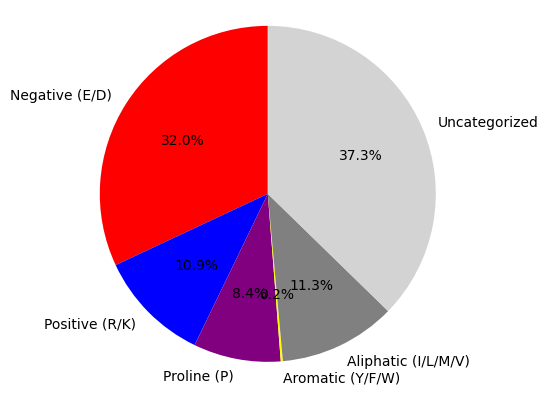

In [137]:
plot_protein_composition('Q96QF7_1_488')

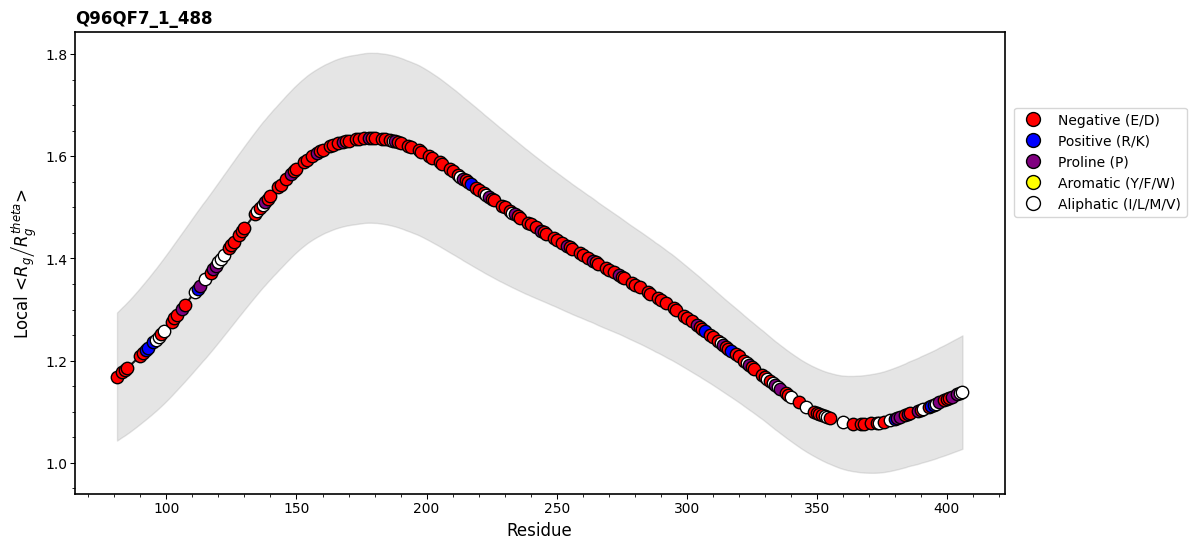

In [66]:
subchain_Rg_Rg_theta_mean_plot(random_protein,12,6)

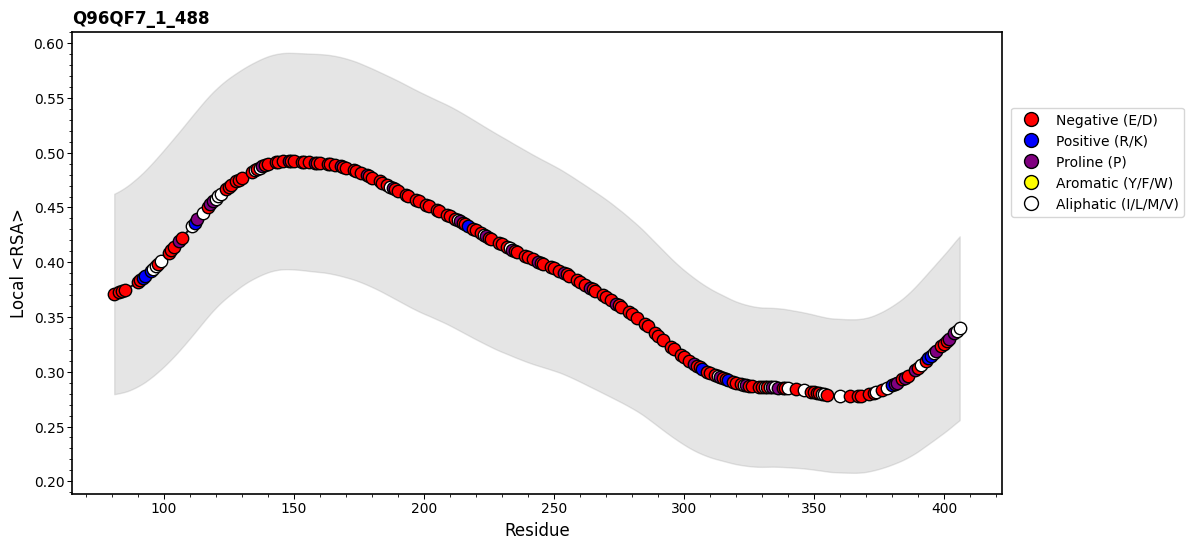

In [67]:
subchain_RSA_plot(random_protein,12,6)

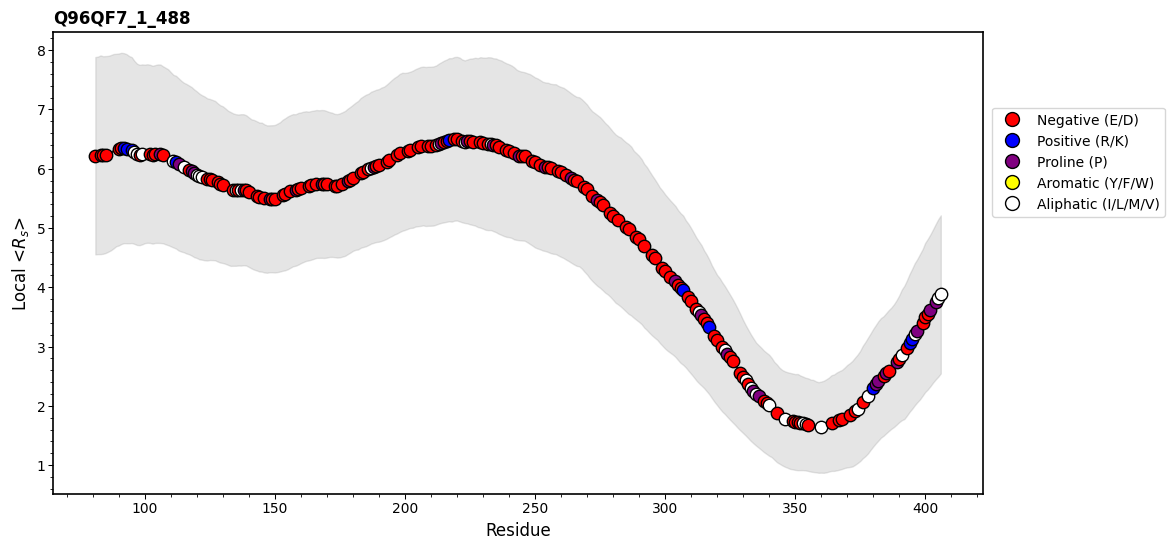

In [68]:
subchain_Rs_plot(random_protein,12,6)

In [52]:
random_protein = compute_kmer_data_from_seq_name('Q9Y4B6_1389_1507',3)
#idrome_prop_flucs[idrome_prop_flucs.nu>0.6]

residue 0 to 39 done
residue 1 to 40 done
residue 2 to 41 done
residue 3 to 42 done
residue 4 to 43 done
residue 5 to 44 done
residue 6 to 45 done
residue 7 to 46 done
residue 8 to 47 done
residue 9 to 48 done
residue 10 to 49 done
residue 11 to 50 done
residue 12 to 51 done
residue 13 to 52 done
residue 14 to 53 done
residue 15 to 54 done
residue 16 to 55 done
residue 17 to 56 done
residue 18 to 57 done
residue 19 to 58 done
residue 20 to 59 done
residue 21 to 60 done
residue 22 to 61 done
residue 23 to 62 done
residue 24 to 63 done
residue 25 to 64 done
residue 26 to 65 done
residue 27 to 66 done
residue 28 to 67 done
residue 29 to 68 done
residue 30 to 69 done
residue 31 to 70 done
residue 32 to 71 done
residue 33 to 72 done
residue 34 to 73 done
residue 35 to 74 done
residue 36 to 75 done
residue 37 to 76 done
residue 38 to 77 done
residue 39 to 78 done
residue 40 to 79 done
residue 41 to 80 done
residue 42 to 81 done
residue 43 to 82 done
residue 44 to 83 done
residue 45 to 84 don

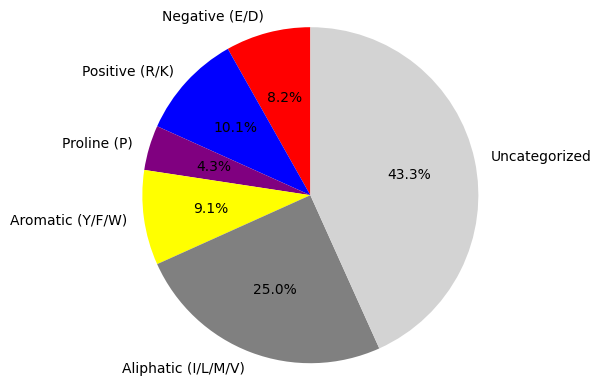

In [58]:
plot_protein_composition('A0AVI2_121_328')

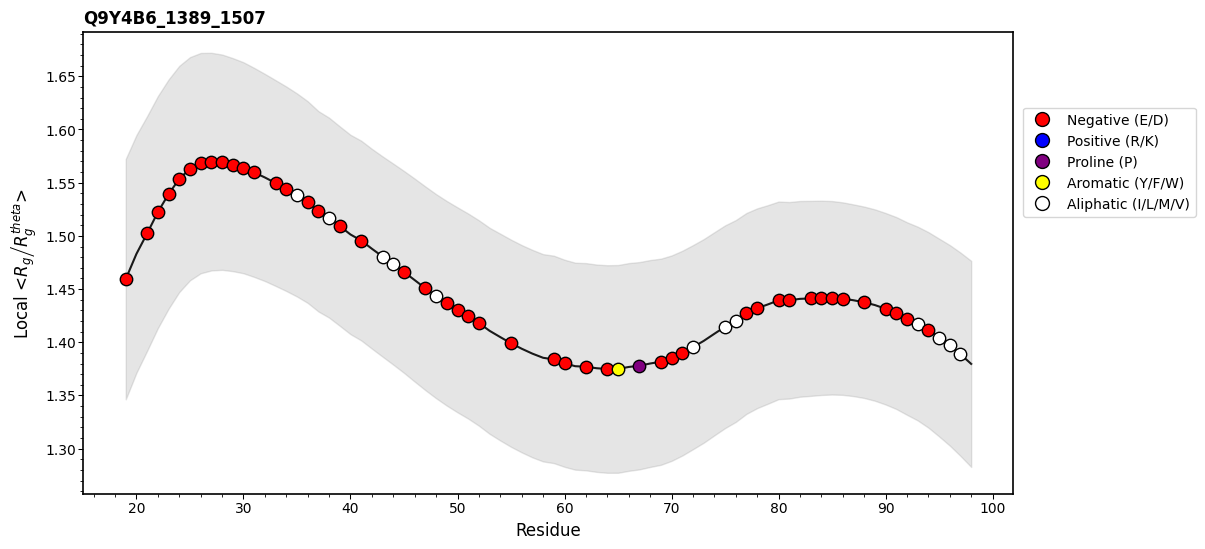

In [54]:
subchain_Rg_Rg_theta_mean_plot(random_protein,12,6)

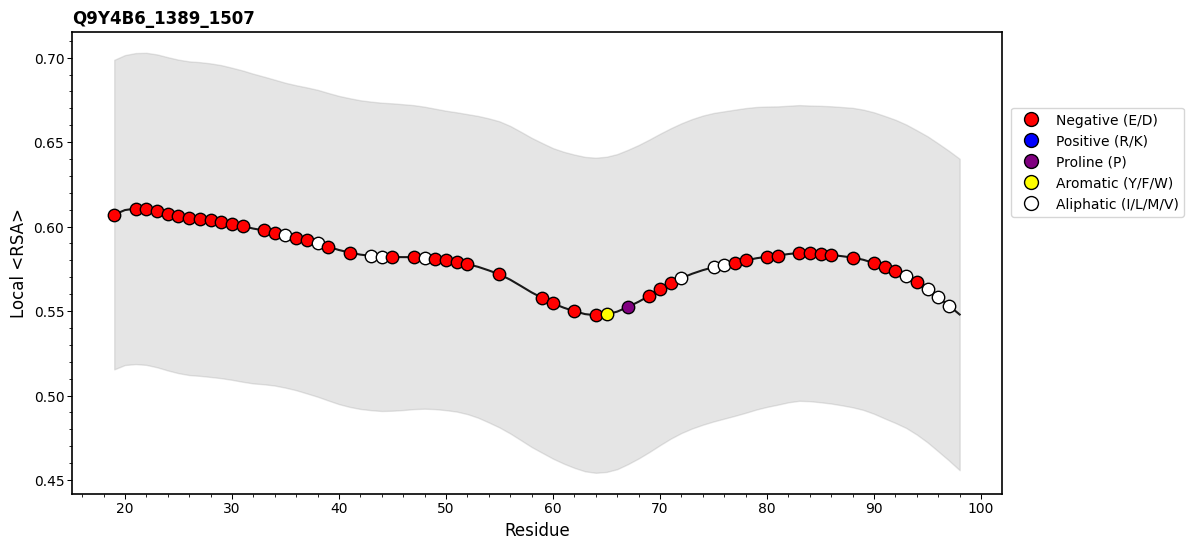

In [55]:
subchain_RSA_plot(random_protein,12,6)

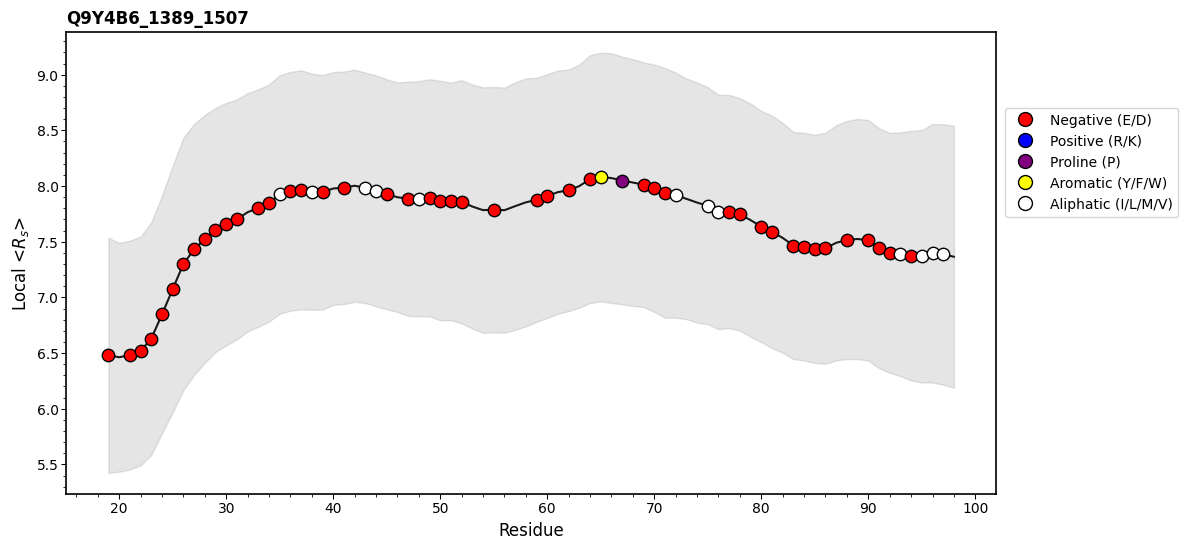

In [56]:
subchain_Rs_plot(random_protein,12,6)

# AFRC demo

In [108]:
from afrc import AnalyticalFRC

# creat an AnalyticalFRC object
P = AnalyticalFRC('MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDI')

## from this object you can calculate various polymeric properties
## directly without any additional information

# get the ensemble-average radius of gyration
mean_rg = P.get_mean_radius_of_gyration()

# get the ensemble-average end-to-end distance
mean_e2e = P.get_mean_end_to_end_distance()

# get the full distribution of the radius of gyration
[bins, p_rg] = P.get_radius_of_gyration_distribution()

# get the full distribution of the distances between residue 4 and 20
[bins, p_r] = P.get_interresidue_distance_distribution(4,20)

In [109]:
idrome_prop_flucs['AFRC_mean_rg_theta

,seq_name,UniProt_ID,N,nu,SPR,ete2_Rg2,S,Delta,Rg/nm,Ree/nm,...,Rs_std,RSA_std,albatross_Rg,albatross_Rg_scaled,albatross_Ree,albatross_Ree_scaled,albatross_scaling_exponent,Rg_range,Rs_range,RSA_range
0,A0A024RBG1_145_181,A0A024RBG1,37,0.558,10.284649,6.304027,0.933961,0.225950,1.606561,3.843011,...,2.620898,0.200553,1.737755,1.737755,4.138554,4.251985,0.578297,0.790029,7.039022,0.537698
1,A0A075B6T7_1_32,A0A075B6T7,32,0.525,10.092351,6.114494,0.901807,0.212670,1.448141,3.390487,...,2.737865,0.201459,1.524150,1.524150,3.321804,3.321804,0.498650,0.756501,7.359276,0.538843
2,A0A087WTH1_1_67,A0A087WTH1,67,0.532,10.160125,6.069995,0.822738,0.199126,2.243991,5.283533,...,2.764873,0.181605,2.407502,2.407502,5.670386,5.788718,0.544833,1.185494,7.414943,0.500908
3,A0A087WTH5_1_132,A0A087WTH5,132,0.496,10.049124,6.150972,0.798438,0.188978,3.034005,7.119714,...,3.071942,0.183702,3.189458,3.189458,7.614085,7.813105,0.504434,1.620033,8.038966,0.485090
4,A0A087WV53_1_46,A0A087WV53,46,0.567,10.212765,6.439589,0.882210,0.214786,1.882622,4.607908,...,2.559872,0.187474,1.984436,1.984436,4.691561,4.962079,0.566668,0.945399,6.813072,0.499202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28053,Q9Y6Z4_1_181,Q9Y6Z4,181,0.493,10.006512,5.748098,0.799905,0.210890,3.791956,8.607822,...,2.880116,0.186104,4.129234,4.129234,9.571439,9.803478,0.534929,2.045043,7.521686,0.492647
28054,Q9Y6Z5_1_254,Q9Y6Z5,254,0.528,9.830710,6.153759,0.896173,0.221422,4.586832,10.808776,...,3.086350,0.192582,4.447731,4.447731,10.693898,10.582268,0.504626,2.664859,7.982766,0.519563
28055,Q9Y6Z7_1_109,Q9Y6Z7,109,0.546,10.025622,6.175505,0.935857,0.216970,3.011145,7.113405,...,2.783294,0.192728,3.285178,3.285178,7.447835,7.863577,0.570739,1.685618,7.465008,0.516141
28056,W6CW81_1_113,W6CW81,113,0.519,10.084249,6.191149,0.843169,0.193880,2.943990,6.975229,...,2.866177,0.187885,3.052207,3.052207,7.340392,7.289317,0.541635,1.597735,7.462810,0.493407
